In [ ]:
#! pip3 install -U jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip3 install -r "/content/drive/MyDrive/datasets/requirements2.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.8 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26535 sha256=2472dd9dd3b6cb9ca99b6bb00b31504b04c1e7c4acb71f31f1bb747f2bfb83de
  Stored in directory: /root/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
Successfully built gpustat


In [ ]:
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()

# MobileNeRF

In [ ]:
#Copyright 2023 The jax3d Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


scene_type = "synthetic"
object_name = "chair"
scene_dir = "/content/drive/MyDrive/datasets/"+object_name

# synthetic
# chair drums ficus hotdog lego materials mic ship

# forwardfacing
# fern flower fortress horns leaves orchids room trex

# real360
# bicycle flowerbed gardenvase stump treehill
# fulllivingroom kitchencounter kitchenlego officebonsai

#%% --------------------------------------------------------------------------------
# ## General imports
#%%
import copy
import gc
import json
import os
import numpy
import cv2
from tqdm import tqdm
import pickle
import jax
import jax.numpy as np
from jax import random
import flax
import flax.linen as nn
import functools
import math
from typing import Sequence, Callable
import time
import matplotlib.pyplot as plt
from PIL import Image
from multiprocessing.pool import ThreadPool

print(jax.local_devices())
if len(jax.local_devices())!=8:
  print("ERROR: need 8 v100 GPUs")
  #1/0
weights_dir = "/content/drive/MyDrive/datasets/weights_100000"
samples_dir = "/content/drive/MyDrive/datasets/samples_100000"
if not os.path.exists(weights_dir):
  os.makedirs(weights_dir)
if not os.path.exists(samples_dir):
  os.makedirs(samples_dir)
def write_floatpoint_image(name,img):
  img = numpy.clip(numpy.array(img)*255,0,255).astype(numpy.uint8)
  cv2.imwrite(name,img[:,:,::-1])

[cuda(id=0)]
ERROR: need 8 v100 GPUs


## Load Datasets

train
  images: (100, 800, 800, 3)
  c2w: (100, 4, 4)
  hwf: (3,)
test
  images: (200, 800, 800, 3)
  c2w: (200, 4, 4)
  hwf: (3,)


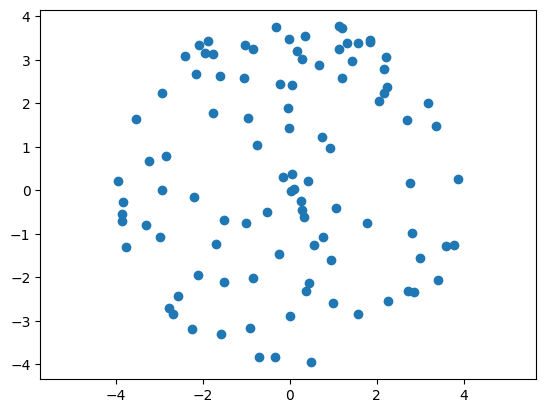

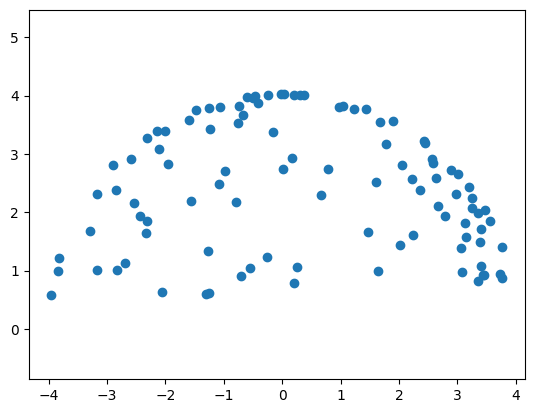

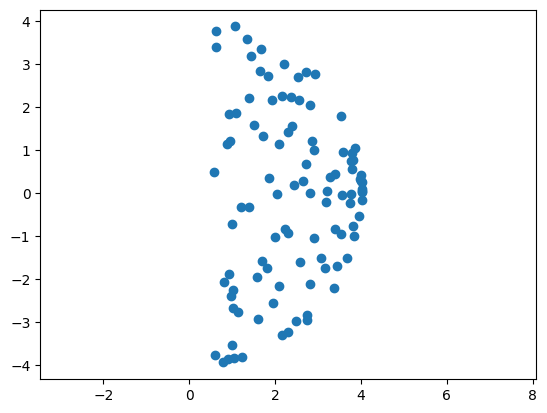

In [ ]:
#% --------------------------------------------------------------------------------
# ## Load the dataset.
#%%
# """ Load dataset """

if scene_type=="synthetic":
  white_bkgd = True
elif scene_type=="forwardfacing":
  white_bkgd = False
elif scene_type=="real360":
  white_bkgd = False


#https://github.com/google-research/google-research/blob/master/snerg/nerf/datasets.py


if scene_type=="synthetic":

  def load_blender(data_dir, split):
    with open(
        os.path.join(data_dir, "transforms_{}.json".format(split)), "r") as fp:
      meta = json.load(fp)

    cams = []
    paths = []
    for i in range(len(meta["frames"])):
      frame = meta["frames"][i]
      cams.append(np.array(frame["transform_matrix"], dtype=np.float32))

      fname = os.path.join(data_dir, frame["file_path"] + ".png")
      paths.append(fname)

    def image_read_fn(fname):
      with open(fname, "rb") as imgin:
        image = np.array(Image.open(imgin), dtype=np.float32) / 255.
      return image
    with ThreadPool() as pool:
      images = pool.map(image_read_fn, paths)
      pool.close()
      pool.join()

    images = np.stack(images, axis=0)
    if white_bkgd:
      images = (images[..., :3] * images[..., -1:] + (1. - images[..., -1:]))
    else:
      images = images[..., :3] * images[..., -1:]

    h, w = images.shape[1:3]
    camera_angle_x = float(meta["camera_angle_x"])
    focal = .5 * w / np.tan(.5 * camera_angle_x)

    hwf = np.array([h, w, focal], dtype=np.float32)
    poses = np.stack(cams, axis=0)
    return {'images' : images, 'c2w' : poses, 'hwf' : hwf}

  data = {'train' : load_blender(scene_dir, 'train'),
          'test' : load_blender(scene_dir, 'test')}

  splits = ['train', 'test']
  for s in splits:
    print(s)
    for k in data[s]:
      print(f'  {k}: {data[s][k].shape}')

  images, poses, hwf = data['train']['images'], data['train']['c2w'], data['train']['hwf']
  write_floatpoint_image(samples_dir+"/training_image_sample.png",images[0])

  for i in range(3):
    plt.figure()
    plt.scatter(poses[:,i,3], poses[:,(i+1)%3,3])
    plt.axis('equal')
    plt.savefig(samples_dir+"/training_camera"+str(i)+".png")

elif scene_type=="forwardfacing" or scene_type=="real360":

  import numpy as np #temporarily use numpy as np, then switch back to jax.numpy
  import jax.numpy as jnp

  def _viewmatrix(z, up, pos):
    """Construct lookat view matrix."""
    vec2 = _normalize(z)
    vec1_avg = up
    vec0 = _normalize(np.cross(vec1_avg, vec2))
    vec1 = _normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m

  def _normalize(x):
    """Normalization helper function."""
    return x / np.linalg.norm(x)

  def _poses_avg(poses):
    """Average poses according to the original NeRF code."""
    hwf = poses[0, :3, -1:]
    center = poses[:, :3, 3].mean(0)
    vec2 = _normalize(poses[:, :3, 2].sum(0))
    up = poses[:, :3, 1].sum(0)
    c2w = np.concatenate([_viewmatrix(vec2, up, center), hwf], 1)
    return c2w

  def _recenter_poses(poses):
    """Recenter poses according to the original NeRF code."""
    poses_ = poses.copy()
    bottom = np.reshape([0, 0, 0, 1.], [1, 4])
    c2w = _poses_avg(poses)
    c2w = np.concatenate([c2w[:3, :4], bottom], -2)
    bottom = np.tile(np.reshape(bottom, [1, 1, 4]), [poses.shape[0], 1, 1])
    poses = np.concatenate([poses[:, :3, :4], bottom], -2)
    poses = np.linalg.inv(c2w) @ poses
    poses_[:, :3, :4] = poses[:, :3, :4]
    poses = poses_
    return poses

  def _transform_poses_pca(poses):
    """Transforms poses so principal components lie on XYZ axes."""
    poses_ = poses.copy()
    t = poses[:, :3, 3]
    t_mean = t.mean(axis=0)
    t = t - t_mean

    eigval, eigvec = np.linalg.eig(t.T @ t)
    # Sort eigenvectors in order of largest to smallest eigenvalue.
    inds = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, inds]
    rot = eigvec.T
    if np.linalg.det(rot) < 0:
      rot = np.diag(np.array([1, 1, -1])) @ rot

    transform = np.concatenate([rot, rot @ -t_mean[:, None]], -1)
    bottom = np.broadcast_to([0, 0, 0, 1.], poses[..., :1, :4].shape)
    pad_poses = np.concatenate([poses[..., :3, :4], bottom], axis=-2)
    poses_recentered = transform @ pad_poses
    poses_recentered = poses_recentered[..., :3, :4]
    transform = np.concatenate([transform, np.eye(4)[3:]], axis=0)

    # Flip coordinate system if z component of y-axis is negative
    if poses_recentered.mean(axis=0)[2, 1] < 0:
      poses_recentered = np.diag(np.array([1, -1, -1])) @ poses_recentered
      transform = np.diag(np.array([1, -1, -1, 1])) @ transform

    # Just make sure it's it in the [-1, 1]^3 cube
    scale_factor = 1. / np.max(np.abs(poses_recentered[:, :3, 3]))
    poses_recentered[:, :3, 3] *= scale_factor
    transform = np.diag(np.array([scale_factor] * 3 + [1])) @ transform

    poses_[:, :3, :4] = poses_recentered[:, :3, :4]
    poses_recentered = poses_
    return poses_recentered, transform

  def load_LLFF(data_dir, split, factor = 4, llffhold = 8):
    # Load images.
    imgdir_suffix = ""
    if factor > 0:
      imgdir_suffix = "_{}".format(factor)
    imgdir = os.path.join(data_dir, "images" + imgdir_suffix)
    if not os.path.exists(imgdir):
      raise ValueError("Image folder {} doesn't exist.".format(imgdir))
    imgfiles = [
        os.path.join(imgdir, f)
        for f in sorted(os.listdir(imgdir))
        if f.endswith("JPG") or f.endswith("jpg") or f.endswith("png")
    ]
    def image_read_fn(fname):
      with open(fname, "rb") as imgin:
        image = np.array(Image.open(imgin), dtype=np.float32) / 255.
      return image
    with ThreadPool() as pool:
      images = pool.map(image_read_fn, imgfiles)
      pool.close()
      pool.join()
    images = np.stack(images, axis=-1)

    # Load poses and bds.
    with open(os.path.join(data_dir, "poses_bounds.npy"),
                          "rb") as fp:
      poses_arr = np.load(fp)
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1, 2, 0])
    bds = poses_arr[:, -2:].transpose([1, 0])
    if poses.shape[-1] != images.shape[-1]:
      raise RuntimeError("Mismatch between imgs {} and poses {}".format(
          images.shape[-1], poses.shape[-1]))

    # Update poses according to downsampling.
    poses[:2, 4, :] = np.array(images.shape[:2]).reshape([2, 1])
    poses[2, 4, :] = poses[2, 4, :] * 1. / factor

    # Correct rotation matrix ordering and move variable dim to axis 0.
    poses = np.concatenate(
        [poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    images = np.moveaxis(images, -1, 0)
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)


    if scene_type=="real360":
      # Rotate/scale poses to align ground with xy plane and fit to unit cube.
      poses, _ = _transform_poses_pca(poses)
    else:
      # Rescale according to a default bd factor.
      scale = 1. / (bds.min() * .75)
      poses[:, :3, 3] *= scale
      bds *= scale
      # Recenter poses
      poses = _recenter_poses(poses)

    # Select the split.
    i_test = np.arange(images.shape[0])[::llffhold]
    i_train = np.array(
        [i for i in np.arange(int(images.shape[0])) if i not in i_test])
    if split == "train":
      indices = i_train
    else:
      indices = i_test
    images = images[indices]
    poses = poses[indices]

    camtoworlds = poses[:, :3, :4]
    focal = poses[0, -1, -1]
    h, w = images.shape[1:3]

    hwf = np.array([h, w, focal], dtype=np.float32)

    return {'images' : jnp.array(images), 'c2w' : jnp.array(camtoworlds), 'hwf' : jnp.array(hwf)}

  data = {'train' : load_LLFF(scene_dir, 'train'),
          'test' : load_LLFF(scene_dir, 'test')}

  splits = ['train', 'test']
  for s in splits:
    print(s)
    for k in data[s]:
      print(f'  {k}: {data[s][k].shape}')

  images, poses, hwf = data['train']['images'], data['train']['c2w'], data['train']['hwf']
  write_floatpoint_image(samples_dir+"/training_image_sample.png",images[0])

  for i in range(3):
    plt.figure()
    plt.scatter(poses[:,i,3], poses[:,(i+1)%3,3])
    plt.axis('equal')
    plt.savefig(samples_dir+"/training_camera"+str(i)+".png")

  bg_color = jnp.mean(images)

## Define helper functions

In [ ]:
import jax.numpy as np
#%% --------------------------------------------------------------------------------
# ## Helper functions
#%%
adam_kwargs = {
    'b1': 0.9,
    'b2': 0.999,
    'eps': 1e-15,
}

n_device = jax.local_device_count()

rng = random.PRNGKey(1)



# General math functions.

def matmul(a, b):
  """jnp.matmul defaults to bfloat16, but this helper function doesn't."""
  return np.matmul(a, b, precision=jax.lax.Precision.HIGHEST)

def normalize(x):
  """Normalization helper function."""
  return x / np.linalg.norm(x, axis=-1, keepdims=True)

def sinusoidal_encoding(position, minimum_frequency_power,
    maximum_frequency_power,include_identity = False):
  # Compute the sinusoidal encoding components
  frequency = 2.0**np.arange(minimum_frequency_power, maximum_frequency_power)
  angle = position[..., None, :] * frequency[:, None]
  encoding = np.sin(np.stack([angle, angle + 0.5 * np.pi], axis=-2))
  # Flatten encoding dimensions
  encoding = encoding.reshape(*position.shape[:-1], -1)
  # Add identity component
  if include_identity:
    encoding = np.concatenate([position, encoding], axis=-1)
  return encoding

# Pose/ray math.

def generate_rays(pixel_coords, pix2cam, cam2world):
  """Generate camera rays from pixel coordinates and poses."""
  homog = np.ones_like(pixel_coords[..., :1])
  pixel_dirs = np.concatenate([pixel_coords + .5, homog], axis=-1)[..., None]
  cam_dirs = matmul(pix2cam, pixel_dirs)
  ray_dirs = matmul(cam2world[..., :3, :3], cam_dirs)[..., 0]
  ray_origins = np.broadcast_to(cam2world[..., :3, 3], ray_dirs.shape)

  #f = 1./pix2cam[0,0]
  #w = -2. * f * pix2cam[0,2]
  #h =  2. * f * pix2cam[1,2]

  return ray_origins, ray_dirs

def pix2cam_matrix(height, width, focal):
  """Inverse intrinsic matrix for a pinhole camera."""
  return  np.array([
      [1./focal, 0, -.5 * width / focal],
      [0, -1./focal, .5 * height / focal],
      [0, 0, -1.],
  ])

def camera_ray_batch_xxxxx_original(cam2world, hwf):
  """Generate rays for a pinhole camera with given extrinsic and intrinsic."""
  height, width = int(hwf[0]), int(hwf[1])
  pix2cam = pix2cam_matrix(*hwf)
  pixel_coords = np.stack(np.meshgrid(np.arange(width), np.arange(height)), axis=-1)
  return generate_rays(pixel_coords, pix2cam, cam2world)

def camera_ray_batch(cam2world, hwf): ### antialiasing by supersampling
  """Generate rays for a pinhole camera with given extrinsic and intrinsic."""
  height, width = int(hwf[0]), int(hwf[1])
  pix2cam = pix2cam_matrix(*hwf)
  x_ind, y_ind = np.meshgrid(np.arange(width), np.arange(height))
  pixel_coords = np.stack([x_ind-0.25, y_ind-0.25, x_ind+0.25, y_ind-0.25,
                  x_ind-0.25, y_ind+0.25, x_ind+0.25, y_ind+0.25], axis=-1)
  pixel_coords = np.reshape(pixel_coords, [height,width,4,2])

  return generate_rays(pixel_coords, pix2cam, cam2world)

def random_ray_batch_xxxxx_original(rng, batch_size, data):
  """Generate a random batch of ray data."""
  keys = random.split(rng, 3)
  cam_ind = random.randint(keys[0], [batch_size], 0, data['c2w'].shape[0])
  y_ind = random.randint(keys[1], [batch_size], 0, data['images'].shape[1])
  x_ind = random.randint(keys[2], [batch_size], 0, data['images'].shape[2])
  pixel_coords = np.stack([x_ind, y_ind], axis=-1)
  pix2cam = pix2cam_matrix(*data['hwf'])
  cam2world = data['c2w'][cam_ind, :3, :4]
  rays = generate_rays(pixel_coords, pix2cam, cam2world)
  pixels = data['images'][cam_ind, y_ind, x_ind]
  return rays, pixels

def random_ray_batch(rng, batch_size, data): ### antialiasing by supersampling
  """Generate a random batch of ray data."""
  keys = random.split(rng, 3)
  cam_ind = random.randint(keys[0], [batch_size], 0, data['c2w'].shape[0])
  y_ind = random.randint(keys[1], [batch_size], 0, data['images'].shape[1])
  y_ind_f = y_ind.astype(np.float32)
  x_ind = random.randint(keys[2], [batch_size], 0, data['images'].shape[2])
  x_ind_f = x_ind.astype(np.float32)
  pixel_coords = np.stack([x_ind_f-0.25, y_ind_f-0.25, x_ind_f+0.25, y_ind_f-0.25,
                  x_ind_f-0.25, y_ind_f+0.25, x_ind_f+0.25, y_ind_f+0.25], axis=-1)
  pixel_coords = np.reshape(pixel_coords, [batch_size,4,2])
  pix2cam = pix2cam_matrix(*data['hwf'])
  cam_ind_x4 = np.tile(cam_ind[..., None], [1,4])
  cam_ind_x4 = np.reshape(cam_ind_x4, [-1])
  cam2world = data['c2w'][cam_ind_x4, :3, :4]
  cam2world = np.reshape(cam2world, [batch_size,4,3,4])
  rays = generate_rays(pixel_coords, pix2cam, cam2world)
  pixels = data['images'][cam_ind, y_ind, x_ind]
  return rays, pixels


# Learning rate helpers.

def log_lerp(t, v0, v1):
  """Interpolate log-linearly from `v0` (t=0) to `v1` (t=1)."""
  if v0 <= 0 or v1 <= 0:
    raise ValueError(f'Interpolants {v0} and {v1} must be positive.')
  lv0 = np.log(v0)
  lv1 = np.log(v1)
  return np.exp(np.clip(t, 0, 1) * (lv1 - lv0) + lv0)

def lr_fn(step, max_steps, lr0, lr1, lr_delay_steps=20000, lr_delay_mult=0.1):
  if lr_delay_steps > 0:
    # A kind of reverse cosine decay.
    delay_rate = lr_delay_mult + (1 - lr_delay_mult) * np.sin(
        0.5 * np.pi * np.clip(step / lr_delay_steps, 0, 1))
  else:
    delay_rate = 1.
  return delay_rate * log_lerp(step / max_steps, lr0, lr1)

#%% --------------------------------------------------------------------------------
# ## Plane parameters and setup
#%%
#scene scales

if scene_type=="synthetic":
  scene_grid_scale = 1.2
  if "hotdog" in scene_dir or "mic" in scene_dir or "ship" in scene_dir:
    scene_grid_scale = 1.5
  grid_min = np.array([-1, -1, -1]) * scene_grid_scale
  grid_max = np.array([ 1,  1,  1]) * scene_grid_scale
  point_grid_size = 128

  def get_taper_coord(p):
    return p
  def inverse_taper_coord(p):
    return p

elif scene_type=="forwardfacing":
  scene_grid_taper = 1.25
  scene_grid_zstart = 25.0
  scene_grid_zend = 1.0
  scene_grid_scale = 0.7
  grid_min = np.array([-scene_grid_scale, -scene_grid_scale,  0])
  grid_max = np.array([ scene_grid_scale,  scene_grid_scale,  1])
  point_grid_size = 128

  def get_taper_coord(p):
    pz = np.maximum(-p[..., 2:3],1e-10)
    px = p[..., 0:1]/(pz*scene_grid_taper)
    py = p[..., 1:2]/(pz*scene_grid_taper)
    pz = (np.log(pz) - np.log(scene_grid_zend))/(np.log(scene_grid_zstart) - np.log(scene_grid_zend))
    return np.concatenate([px,py,pz],axis=-1)
  def inverse_taper_coord(p):
    pz = np.exp( p[..., 2:3] * \
          (np.log(scene_grid_zstart) - np.log(scene_grid_zend)) + \
          np.log(scene_grid_zend) )
    px = p[..., 0:1]*(pz*scene_grid_taper)
    py = p[..., 1:2]*(pz*scene_grid_taper)
    pz = -pz
    return np.concatenate([px,py,pz],axis=-1)

elif scene_type=="real360":
  scene_grid_zmax = 16.0
  if object_name == "gardenvase":
    scene_grid_zmax = 9.0
  grid_min = np.array([-1, -1, -1])
  grid_max = np.array([ 1,  1,  1])
  point_grid_size = 128

  def get_taper_coord(p):
    return p
  def inverse_taper_coord(p):
    return p

  #approximate solution of e^x = ax+b
  #(np.exp( x ) + (x-1)) / x = scene_grid_zmax
  #np.exp( x ) - scene_grid_zmax*x + (x-1) = 0
  scene_grid_zcc = -1
  for i in range(10000):
    j = numpy.log(scene_grid_zmax)+i/1000.0
    if numpy.exp(j) - scene_grid_zmax*j + (j-1) >0:
      scene_grid_zcc = j
      break
  if scene_grid_zcc<0:
    print("ERROR: approximate solution of e^x = ax+b failed")
    1/0



grid_dtype = np.float32

#plane parameter grid
point_grid = np.zeros(
      (point_grid_size, point_grid_size, point_grid_size, 3),
      dtype=grid_dtype)
acc_grid = np.zeros(
      (point_grid_size, point_grid_size, point_grid_size),
      dtype=grid_dtype)
point_grid_diff_lr_scale = 16.0/point_grid_size



def get_acc_grid_masks(taper_positions, acc_grid):
  grid_positions = (taper_positions - grid_min) * \
                    (point_grid_size / (grid_max - grid_min) )
  grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
              & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
              & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)
  grid_positions = grid_positions*grid_masks[..., None]
  grid_indices = grid_positions.astype(np.int32)

  acc_grid_masks = acc_grid[grid_indices[...,0],grid_indices[...,1],grid_indices[...,2]]
  acc_grid_masks = acc_grid_masks*grid_masks

  return acc_grid_masks


#%% --------------------------------------------------------------------------------
# ## MLP setup
#%%
num_bottleneck_features = 8


def dense_layer(width):
  return nn.Dense(
      width, kernel_init=jax.nn.initializers.glorot_uniform())
def dense_layer_zero(width):
  return nn.Dense(
      width, kernel_init=jax.nn.initializers.zeros)

class RadianceField(nn.Module):
  """TODO(drebain) docstring."""
  out_dim: int
  trunk_width: int = 384
  trunk_depth: int = 8
  trunk_skip_length: int = 4
  network_activation: Callable = nn.relu
  position_encoding_max_frequency_power: int = 10
  @nn.compact
  def __call__(self, positions):
    inputs = sinusoidal_encoding(
        positions, 0, self.position_encoding_max_frequency_power)
    net = inputs
    for i in range(self.trunk_depth):
      net = dense_layer(self.trunk_width)(net)
      net = self.network_activation(net)
      if i % self.trunk_skip_length == 0 and i > 0:
        net = np.concatenate([net, inputs], axis=-1)

    net = dense_layer(self.out_dim)(net)

    return net

# Set up the MLPs for color and density.
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


density_model = RadianceField(1)
feature_model = RadianceField(num_bottleneck_features)
color_model = MLP([16,16,3])

# These are the variables we will be optimizing during trianing.
model_vars = [point_grid, acc_grid,
              density_model.init(
                  jax.random.PRNGKey(0),
                  np.zeros([1, 3])),
              feature_model.init(
                  jax.random.PRNGKey(0),
                  np.zeros([1, 3])),
              color_model.init(
                  jax.random.PRNGKey(0),
                  np.zeros([1, 3+num_bottleneck_features])),
              ]

#avoid bugs
point_grid = None
acc_grid = None


## Mesh Rendering

In [ ]:
#%% --------------------------------------------------------------------------------
# ## Load weights
#%%
vars = pickle.load(open(weights_dir+"/"+"weights_stage2_1.pkl", "rb"))
model_vars = vars
#%% --------------------------------------------------------------------------------
# ## Get mesh
#%%

In [ ]:
import gpustat


# List to store GPU memory consumption
gpu_memory_consumption = []

# Time taken for the entire training
total_training_start= time.time()

step_gpu=0

In [ ]:


#%%
#extract mesh vertices
layer_num = point_grid_size

v_grid = numpy.zeros([layer_num+1,layer_num+1,layer_num+1,3], numpy.float32)
v_grid[:-1,:-1,:-1] = numpy.array(vars[0])*point_grid_diff_lr_scale
#%%
#get UV coordinates

if scene_type=="synthetic":
  texture_size = 1024*2
  batch_num = 8*8*8
elif scene_type=="forwardfacing":
  texture_size = 1024*2
  batch_num = 8*8*8
elif scene_type=="real360":
  texture_size = 1024*2
  batch_num = 8*8*8

test_threshold = 0.1 #edit 0.1


out_feat_num = num_bottleneck_features//4

quad_size = texture_size//layer_num
assert quad_size*layer_num == texture_size
#pre-compute weights for each quad
# 0 - 1 x
# | \ |
# 2 - 3
# y
quad_weights = numpy.zeros([quad_size,quad_size,4],numpy.float32)
for i in range(quad_size):
  for j in range(quad_size):
    x = (i)/quad_size
    y = (j)/quad_size
    if x>y:
      quad_weights[i,j,0] = 1-x
      quad_weights[i,j,1] = x-y
      quad_weights[i,j,2] = 0
      quad_weights[i,j,3] = y
    else:
      quad_weights[i,j,0] = 1-y
      quad_weights[i,j,1] = 0
      quad_weights[i,j,2] = y-x
      quad_weights[i,j,3] = x
quad_weights = numpy.reshape(quad_weights,[quad_size*quad_size,4])
quad_weights = numpy.transpose(quad_weights, (1,0)) #[4,quad_size*quad_size]

grid_max_numpy = numpy.array(grid_max,numpy.float32)
grid_min_numpy = numpy.array(grid_min,numpy.float32)

i_grid = numpy.zeros([layer_num,layer_num,layer_num],numpy.int32)
j_grid = numpy.zeros([layer_num,layer_num,layer_num],numpy.int32)
k_grid = numpy.zeros([layer_num,layer_num,layer_num],numpy.int32)

i_grid[:,:,:] = numpy.reshape(numpy.arange(layer_num),[-1,1,1])
j_grid[:,:,:] = numpy.reshape(numpy.arange(layer_num),[1,-1,1])
k_grid[:,:,:] = numpy.reshape(numpy.arange(layer_num),[1,1,-1])



def get_density_color(pts, vars):
  #redefine net

  acc_grid_masks = get_acc_grid_masks(pts, vars[1])

  # Now use the MLP to compute density and features
  mlp_alpha = density_model.apply(vars[-3], pts)
  mlp_alpha = jax.nn.sigmoid(mlp_alpha[..., 0]-8)
  mlp_alpha = mlp_alpha * (acc_grid_masks>=test_threshold)
  mlp_alpha = (mlp_alpha>0.5).astype(np.uint8)#EDIT (mlp_alpha>0.5).astype(np.uint8)

  #previous: (features+dirs)->MLP->(RGB)
  mlp_features = jax.nn.sigmoid(feature_model.apply(vars[-2], pts))
  #discretize
  mlp_features_ = np.round(mlp_features*255).astype(np.uint8)
  mlp_features_0 = np.clip(mlp_features_[...,0:1],1,255)*mlp_alpha[..., None]
  mlp_features_1 = mlp_features_[...,1:]*mlp_alpha[..., None]
  mlp_features_ = np.concatenate([mlp_features_0,mlp_features_1],axis=-1)

  return mlp_features_

get_density_color_p = jax.pmap(lambda pts, vars: get_density_color(pts,vars),
    in_axes=(0, None))



def get_feature_png(feat):
  h,w,c = feat.shape
  #deal with opencv BGR->RGB
  if c%4!=0:
    print("ERROR: c%4!=0")
    1/0
  out = []
  for i in range(out_feat_num):
    ff = numpy.zeros([h,w,4],numpy.uint8)
    ff[...,0] = feat[..., i*4+2]
    ff[...,1] = feat[..., i*4+1]
    ff[...,2] = feat[..., i*4+0]
    ff[...,3] = feat[..., i*4+3]
    out.append(ff)
  return out

gpu_stats = gpustat.new_query().jsonify() #EDIT
gpu_memory_consumption.append({
            "iteration": step_gpu,
            "gpu_stats": gpu_stats
   })

##### z planes

x,y,z = j_grid,k_grid,i_grid
p0 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = j_grid+1,k_grid,i_grid
p1 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = j_grid,k_grid+1,i_grid
p2 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = j_grid+1,k_grid+1,i_grid
p3 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
p0123 = numpy.stack([p0,p1,p2,p3],axis=-1) #[M,N,K,3,4]
p0123 = p0123 @ quad_weights #[M,N,K,3,quad_size*quad_size]
p0123 = numpy.reshape(p0123, [layer_num,layer_num,layer_num,3,quad_size,quad_size]) #[M,N,K,3,quad_size,quad_size]
p0123 = numpy.transpose(p0123, (0,1,4,2,5,3)) #[M,N,quad_size,K,quad_size,3]
#positions_z = numpy.reshape(numpy.ascontiguousarray(p0123), [layer_num,layer_num*quad_size,layer_num*quad_size,3])
positions_z = numpy.reshape(numpy.ascontiguousarray(p0123), [-1,3])

p0 = None
p1 = None
p2 = None
p3 = None
p0123 = None

total_len = len(positions_z)
batch_len = total_len//batch_num
coarse_feature_z = numpy.zeros([total_len,num_bottleneck_features],numpy.uint8)
for i in range(batch_num):
  t0 = numpy.reshape(positions_z[i*batch_len:(i+1)*batch_len], [n_device,-1,3])
  t0 = get_density_color_p(t0,vars)
  coarse_feature_z[i*batch_len:(i+1)*batch_len] = numpy.reshape(t0,[-1,num_bottleneck_features])
coarse_feature_z = numpy.reshape(coarse_feature_z,[layer_num,texture_size,texture_size,num_bottleneck_features])
coarse_feature_z[:,-quad_size:,:] = 0
coarse_feature_z[:,:,-quad_size:] = 0

positions_z = None


buffer_z = []
for i in range(layer_num):
  if not numpy.any(coarse_feature_z[i,:,:,0]>0):
    buffer_z.append(None)
    continue
  feats = get_feature_png(coarse_feature_z[i])
  buffer_z.append(feats)

coarse_feature_z = None



step_gpu=step_gpu+1
gpu_stats = gpustat.new_query().jsonify() #EDIT
gpu_memory_consumption.append({
            "iteration": step_gpu,
            "gpu_stats": gpu_stats
   })

##### x planes

x,y,z = i_grid,j_grid,k_grid
p0 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = i_grid,j_grid+1,k_grid
p1 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = i_grid,j_grid,k_grid+1
p2 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = i_grid,j_grid+1,k_grid+1
p3 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
p0123 = numpy.stack([p0,p1,p2,p3],axis=-1) #[M,N,K,3,4]
p0123 = p0123 @ quad_weights #[M,N,K,3,quad_size*quad_size]
p0123 = numpy.reshape(p0123, [layer_num,layer_num,layer_num,3,quad_size,quad_size]) #[M,N,K,3,quad_size,quad_size]
p0123 = numpy.transpose(p0123, (0,1,4,2,5,3)) #[M,N,quad_size,K,quad_size,3]
#positions_x = numpy.reshape(numpy.ascontiguousarray(p0123), [layer_num,layer_num*quad_size,layer_num*quad_size,3])
positions_x = numpy.reshape(numpy.ascontiguousarray(p0123), [-1,3])

p0 = None
p1 = None
p2 = None
p3 = None
p0123 = None

total_len = len(positions_x)
batch_len = total_len//batch_num
coarse_feature_x = numpy.zeros([total_len,num_bottleneck_features],numpy.uint8)
for i in range(batch_num):
  t0 = numpy.reshape(positions_x[i*batch_len:(i+1)*batch_len], [n_device,-1,3])
  t0 = get_density_color_p(t0,vars)
  coarse_feature_x[i*batch_len:(i+1)*batch_len] = numpy.reshape(t0,[-1,num_bottleneck_features])
coarse_feature_x = numpy.reshape(coarse_feature_x,[layer_num,texture_size,texture_size,num_bottleneck_features])
coarse_feature_x[:,-quad_size:,:] = 0
coarse_feature_x[:,:,-quad_size:] = 0

positions_x = None

buffer_x = []
for i in range(layer_num):
  if not numpy.any(coarse_feature_x[i,:,:,0]>0):
    buffer_x.append(None)
    continue
  feats = get_feature_png(coarse_feature_x[i])
  buffer_x.append(feats)

coarse_feature_x = None


step_gpu=step_gpu+1
gpu_stats = gpustat.new_query().jsonify() #EDIT
gpu_memory_consumption.append({
            "iteration": step_gpu,
            "gpu_stats": gpu_stats
   })

##### y planes

x,y,z = j_grid,i_grid,k_grid
p0 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = j_grid+1,i_grid,k_grid
p1 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = j_grid,i_grid,k_grid+1
p2 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
x,y,z = j_grid+1,i_grid,k_grid+1
p3 = v_grid[x,y,z] + (numpy.stack([x,y,z],axis=-1).astype(numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
p0123 = numpy.stack([p0,p1,p2,p3],axis=-1) #[M,N,K,3,4]
p0123 = p0123 @ quad_weights #[M,N,K,3,quad_size*quad_size]
p0123 = numpy.reshape(p0123, [layer_num,layer_num,layer_num,3,quad_size,quad_size]) #[M,N,K,3,quad_size,quad_size]
p0123 = numpy.transpose(p0123, (0,1,4,2,5,3)) #[M,N,quad_size,K,quad_size,3]
#positions_y = numpy.reshape(numpy.ascontiguousarray(p0123), [layer_num,layer_num*quad_size,layer_num*quad_size,3])
positions_y = numpy.reshape(numpy.ascontiguousarray(p0123), [-1,3])

p0 = None
p1 = None
p2 = None
p3 = None
p0123 = None

total_len = len(positions_y)
batch_len = total_len//batch_num
coarse_feature_y = numpy.zeros([total_len,num_bottleneck_features],numpy.uint8)
for i in range(batch_num):
  t0 = numpy.reshape(positions_y[i*batch_len:(i+1)*batch_len], [n_device,-1,3])
  t0 = get_density_color_p(t0,vars)
  coarse_feature_y[i*batch_len:(i+1)*batch_len] = numpy.reshape(t0,[-1,num_bottleneck_features])
coarse_feature_y = numpy.reshape(coarse_feature_y,[layer_num,texture_size,texture_size,num_bottleneck_features])
coarse_feature_y[:,-quad_size:,:] = 0
coarse_feature_y[:,:,-quad_size:] = 0

positions_y = None

buffer_y = []
for i in range(layer_num):
  if not numpy.any(coarse_feature_y[i,:,:,0]>0):
    buffer_y.append(None)
    continue
  feats = get_feature_png(coarse_feature_y[i])
  buffer_y.append(feats)

coarse_feature_y = None


step_gpu=step_gpu+1
gpu_stats = gpustat.new_query().jsonify() #EDIT
gpu_memory_consumption.append({
            "iteration": step_gpu,
            "gpu_stats": gpu_stats
   })


In [ ]:
# Count the number of None values in buffer_z
none_count = sum(feature is None for feature in buffer_z)

# Calculate the percentage
percentage_none = (none_count / len(buffer_z)) * 100

print(f"Number of None values in buffer_z: {none_count}")
print(f"Percentage of None values: {percentage_none:.2f}%")


Number of None values in buffer_z: 18
Percentage of None values: 14.06%


In [ ]:
write_floatpoint_image(samples_dir+"/s3_slice_sample.png",buffer_z[layer_num//2][0]/255.0)


In [ ]:
out_img_size = 1024*20
out_img = []
for i in range(out_feat_num):
  out_img.append(numpy.zeros([out_img_size,out_img_size,4], numpy.uint8))
out_cell_num = 0
out_cell_size = quad_size+1
out_img_h = out_img_size//out_cell_size
out_img_w = out_img_size//out_cell_size



if scene_type=="synthetic":
  def inverse_taper_coord_numpy(p):
    return p

elif scene_type=="forwardfacing":
  def inverse_taper_coord_numpy(p):
    pz = numpy.exp( p[..., 2:3] * \
          (numpy.log(scene_grid_zstart) - numpy.log(scene_grid_zend)) + \
          numpy.log(scene_grid_zend) )
    px = p[..., 0:1]*(pz*scene_grid_taper)
    py = p[..., 1:2]*(pz*scene_grid_taper)
    pz = -pz
    return numpy.concatenate([px,py,pz],axis=-1)

elif scene_type=="real360":
  def inverse_taper_coord_numpy(p):
    return p



def write_patch_to_png(out_img,out_cell_num,out_img_w,j,k,feats):
  py = out_cell_num//out_img_w
  px = out_cell_num%out_img_w

  osy = j*quad_size
  oey = j*quad_size+out_cell_size
  tsy = py*out_cell_size
  tey = py*out_cell_size+out_cell_size
  osx = k*quad_size
  oex = k*quad_size+out_cell_size
  tsx = px*out_cell_size
  tex = px*out_cell_size+out_cell_size

  for i in range(out_feat_num):
    out_img[i][tsy:tey,tsx:tex] = feats[i][osy:oey,osx:oex]

def get_png_uv(out_cell_num,out_img_w,out_img_size):
  py = out_cell_num//out_img_w
  px = out_cell_num%out_img_w

  uv0 = numpy.array([py*out_cell_size+0.5,     px*out_cell_size+0.5],numpy.float32)/out_img_size
  uv1 = numpy.array([(py+1)*out_cell_size-0.5, px*out_cell_size+0.5],numpy.float32)/out_img_size
  uv2 = numpy.array([py*out_cell_size+0.5,     (px+1)*out_cell_size-0.5],numpy.float32)/out_img_size
  uv3 = numpy.array([(py+1)*out_cell_size-0.5, (px+1)*out_cell_size-0.5],numpy.float32)/out_img_size

  return uv0,uv1,uv2,uv3


#for eval
point_UV_grid = numpy.zeros([point_grid_size,point_grid_size,point_grid_size,3,4,2], numpy.float32)

#mesh vertices
bag_of_v = []


#synthetic and real360
#up is z-
#order: z-,x+,y+
if scene_type=="synthetic" or scene_type=="real360":
  for k in range(layer_num-1,-1,-1):
    for i in range(layer_num):
      for j in range(layer_num):

        # z plane
        if not(k==0 or k==layer_num-1 or i==layer_num-1 or j==layer_num-1):
          feats = buffer_z[k]
          if feats is not None and numpy.max(feats[0][i*quad_size:(i+1)*quad_size+1,j*quad_size:(j+1)*quad_size+1,2])>0:

            write_patch_to_png(out_img,out_cell_num,out_img_w,i,j,feats)
            uv0,uv1,uv2,uv3 = get_png_uv(out_cell_num,out_img_w,out_img_size)
            out_cell_num += 1

            p0 = v_grid[i,j,k] + (numpy.array([i,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p1 = v_grid[i+1,j,k] + (numpy.array([i+1,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p2 = v_grid[i,j+1,k] + (numpy.array([i,j+1,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p3 = v_grid[i+1,j+1,k] + (numpy.array([i+1,j+1,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy

            p0 = inverse_taper_coord_numpy(p0)
            p1 = inverse_taper_coord_numpy(p1)
            p2 = inverse_taper_coord_numpy(p2)
            p3 = inverse_taper_coord_numpy(p3)

            point_UV_grid[i,j,k,2,0] = uv0
            point_UV_grid[i,j,k,2,1] = uv1
            point_UV_grid[i,j,k,2,2] = uv2
            point_UV_grid[i,j,k,2,3] = uv3

            bag_of_v.append([p0,p1,p2,p3])

        # x plane
        if not(i==0 or i==layer_num-1 or j==layer_num-1 or k==layer_num-1):
          feats = buffer_x[i]
          if feats is not None and numpy.max(feats[0][j*quad_size:(j+1)*quad_size+1,k*quad_size:(k+1)*quad_size+1,2])>0:

            write_patch_to_png(out_img,out_cell_num,out_img_w,j,k,feats)
            uv0,uv1,uv2,uv3 = get_png_uv(out_cell_num,out_img_w,out_img_size)
            out_cell_num += 1

            p0 = v_grid[i,j,k] + (numpy.array([i,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p1 = v_grid[i,j+1,k] + (numpy.array([i,j+1,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p2 = v_grid[i,j,k+1] + (numpy.array([i,j,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p3 = v_grid[i,j+1,k+1] + (numpy.array([i,j+1,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy

            p0 = inverse_taper_coord_numpy(p0)
            p1 = inverse_taper_coord_numpy(p1)
            p2 = inverse_taper_coord_numpy(p2)
            p3 = inverse_taper_coord_numpy(p3)

            point_UV_grid[i,j,k,0,0] = uv0
            point_UV_grid[i,j,k,0,1] = uv1
            point_UV_grid[i,j,k,0,2] = uv2
            point_UV_grid[i,j,k,0,3] = uv3

            bag_of_v.append([p0,p1,p2,p3])

        # y plane
        if not(j==0 or j==layer_num-1 or i==layer_num-1 or k==layer_num-1):
          feats = buffer_y[j]
          if feats is not None and numpy.max(feats[0][i*quad_size:(i+1)*quad_size+1,k*quad_size:(k+1)*quad_size+1,2])>0:

            write_patch_to_png(out_img,out_cell_num,out_img_w,i,k,feats)
            uv0,uv1,uv2,uv3 = get_png_uv(out_cell_num,out_img_w,out_img_size)
            out_cell_num += 1

            p0 = v_grid[i,j,k] + (numpy.array([i,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p1 = v_grid[i+1,j,k] + (numpy.array([i+1,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p2 = v_grid[i,j,k+1] + (numpy.array([i,j,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p3 = v_grid[i+1,j,k+1] + (numpy.array([i+1,j,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy

            p0 = inverse_taper_coord_numpy(p0)
            p1 = inverse_taper_coord_numpy(p1)
            p2 = inverse_taper_coord_numpy(p2)
            p3 = inverse_taper_coord_numpy(p3)

            point_UV_grid[i,j,k,1,0] = uv0
            point_UV_grid[i,j,k,1,1] = uv1
            point_UV_grid[i,j,k,1,2] = uv2
            point_UV_grid[i,j,k,1,3] = uv3

            bag_of_v.append([p0,p1,p2,p3])





#forwardfacing
#front is z-
#order: z+,x+,y+
elif scene_type=="forwardfacing":
  for k in range(layer_num):
    for i in range(layer_num):
      for j in range(layer_num):

        # z plane
        if not(k==0 or k==layer_num-1 or i==layer_num-1 or j==layer_num-1):
          feats = buffer_z[k]
          if feats is not None and numpy.max(feats[0][i*quad_size:(i+1)*quad_size+1,j*quad_size:(j+1)*quad_size+1,2])>0:

            write_patch_to_png(out_img,out_cell_num,out_img_w,i,j,feats)
            uv0,uv1,uv2,uv3 = get_png_uv(out_cell_num,out_img_w,out_img_size)
            out_cell_num += 1

            p0 = v_grid[i,j,k] + (numpy.array([i,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p1 = v_grid[i+1,j,k] + (numpy.array([i+1,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p2 = v_grid[i,j+1,k] + (numpy.array([i,j+1,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p3 = v_grid[i+1,j+1,k] + (numpy.array([i+1,j+1,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy

            p0 = inverse_taper_coord_numpy(p0)
            p1 = inverse_taper_coord_numpy(p1)
            p2 = inverse_taper_coord_numpy(p2)
            p3 = inverse_taper_coord_numpy(p3)

            point_UV_grid[i,j,k,2,0] = uv0
            point_UV_grid[i,j,k,2,1] = uv1
            point_UV_grid[i,j,k,2,2] = uv2
            point_UV_grid[i,j,k,2,3] = uv3

            bag_of_v.append([p0,p1,p2,p3])

        # x plane
        if not(i==0 or i==layer_num-1 or j==layer_num-1 or k==layer_num-1):
          feats = buffer_x[i]
          if feats is not None and numpy.max(feats[0][j*quad_size:(j+1)*quad_size+1,k*quad_size:(k+1)*quad_size+1,2])>0:

            write_patch_to_png(out_img,out_cell_num,out_img_w,j,k,feats)
            uv0,uv1,uv2,uv3 = get_png_uv(out_cell_num,out_img_w,out_img_size)
            out_cell_num += 1

            p0 = v_grid[i,j,k] + (numpy.array([i,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p1 = v_grid[i,j+1,k] + (numpy.array([i,j+1,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p2 = v_grid[i,j,k+1] + (numpy.array([i,j,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p3 = v_grid[i,j+1,k+1] + (numpy.array([i,j+1,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy

            p0 = inverse_taper_coord_numpy(p0)
            p1 = inverse_taper_coord_numpy(p1)
            p2 = inverse_taper_coord_numpy(p2)
            p3 = inverse_taper_coord_numpy(p3)

            point_UV_grid[i,j,k,0,0] = uv0
            point_UV_grid[i,j,k,0,1] = uv1
            point_UV_grid[i,j,k,0,2] = uv2
            point_UV_grid[i,j,k,0,3] = uv3

            bag_of_v.append([p0,p1,p2,p3])

        # y plane
        if not(j==0 or j==layer_num-1 or i==layer_num-1 or k==layer_num-1):
          feats = buffer_y[j]
          if feats is not None and numpy.max(feats[0][i*quad_size:(i+1)*quad_size+1,k*quad_size:(k+1)*quad_size+1,2])>0:

            write_patch_to_png(out_img,out_cell_num,out_img_w,i,k,feats)
            uv0,uv1,uv2,uv3 = get_png_uv(out_cell_num,out_img_w,out_img_size)
            out_cell_num += 1

            p0 = v_grid[i,j,k] + (numpy.array([i,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p1 = v_grid[i+1,j,k] + (numpy.array([i+1,j,k],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p2 = v_grid[i,j,k+1] + (numpy.array([i,j,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy
            p3 = v_grid[i+1,j,k+1] + (numpy.array([i+1,j,k+1],numpy.float32)+0.5)*((grid_max_numpy - grid_min_numpy)/point_grid_size) + grid_min_numpy

            p0 = inverse_taper_coord_numpy(p0)
            p1 = inverse_taper_coord_numpy(p1)
            p2 = inverse_taper_coord_numpy(p2)
            p3 = inverse_taper_coord_numpy(p3)

            point_UV_grid[i,j,k,1,0] = uv0
            point_UV_grid[i,j,k,1,1] = uv1
            point_UV_grid[i,j,k,1,2] = uv2
            point_UV_grid[i,j,k,1,3] = uv3

            bag_of_v.append([p0,p1,p2,p3])



print("Number of quad faces:", out_cell_num)

step_gpu=step_gpu+1
gpu_stats = gpustat.new_query().jsonify() #EDIT
gpu_memory_consumption.append({
            "iteration": step_gpu,
            "gpu_stats": gpu_stats
   })

Number of quad faces: 135146


In [ ]:
buffer_x = None
buffer_y = None
buffer_z = None
#%% --------------------------------------------------------------------------------
# ## Main rendering functions
#%%

#compute ray-gridcell intersections

if scene_type=="synthetic":

  def gridcell_from_rays(rays):
    ray_origins = rays[0]
    ray_directions = rays[1]

    dtype = ray_origins.dtype
    batch_shape = ray_origins.shape[:-1]
    small_step = 1e-5
    epsilon = 1e-5

    ox = ray_origins[..., 0:1]
    oy = ray_origins[..., 1:2]
    oz = ray_origins[..., 2:3]

    dx = ray_directions[..., 0:1]
    dy = ray_directions[..., 1:2]
    dz = ray_directions[..., 2:3]

    dxm = (np.abs(dx)<epsilon).astype(dtype)
    dym = (np.abs(dy)<epsilon).astype(dtype)
    dzm = (np.abs(dz)<epsilon).astype(dtype)

    #avoid zero div
    dx = dx+dxm
    dy = dy+dym
    dz = dz+dzm

    layers = np.arange(point_grid_size+1,dtype=dtype)/point_grid_size #[0,1]
    layers = np.reshape(layers, [1]*len(batch_shape)+[point_grid_size+1])
    layers = np.broadcast_to(layers, list(batch_shape)+[point_grid_size+1])

    tx = ((layers*(grid_max[0]-grid_min[0])+grid_min[0])-ox)/dx
    ty = ((layers*(grid_max[1]-grid_min[1])+grid_min[1])-oy)/dy
    tz = ((layers*(grid_max[2]-grid_min[2])+grid_min[2])-oz)/dz

    tx = tx*(1-dxm) + 1000*dxm
    ty = ty*(1-dym) + 1000*dym
    tz = tz*(1-dzm) + 1000*dzm

    txyz = np.concatenate([tx, ty, tz], axis=-1)
    txyzm = (txyz<=0).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm


    # not using acc_grid
    txyz = txyz + small_step


    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]


    grid_positions = (world_positions - grid_min) * \
                      (point_grid_size / (grid_max - grid_min) )

    grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
                & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
                & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)

    grid_positions = grid_positions*grid_masks[..., None] \
              + np.logical_not(grid_masks[..., None]) #min=1,max=point_grid_size-2
    grid_indices = grid_positions.astype(np.int32)

    return grid_indices, grid_masks

elif scene_type=="forwardfacing":

  def gridcell_from_rays(rays):
    ray_origins = rays[0]
    ray_directions = rays[1]

    dtype = ray_origins.dtype
    batch_shape = ray_origins.shape[:-1]
    small_step = 1e-5
    epsilon = 1e-10

    ox = ray_origins[..., 0:1]
    oy = ray_origins[..., 1:2]
    oz = ray_origins[..., 2:3]

    dx = ray_directions[..., 0:1]
    dy = ray_directions[..., 1:2]
    dz = ray_directions[..., 2:3]


    layers = np.arange(point_grid_size+1,dtype=dtype)/point_grid_size #[0,1]
    layers = np.reshape(layers, [1]*len(batch_shape)+[point_grid_size+1])
    layers = np.broadcast_to(layers, list(batch_shape)+[point_grid_size+1])


    #z planes
    #z = Zlayers
    #dz*t + oz = Zlayers
    Zlayers = -np.exp( layers * \
          (np.log(scene_grid_zstart) - np.log(scene_grid_zend)) + \
          np.log(scene_grid_zend) )
    dzm = (np.abs(dz)<epsilon).astype(dtype)
    dz = dz+dzm
    tz = (Zlayers-oz)/dz
    tz = tz*(1-dzm) + 1000*dzm

    #x planes
    #x/z = Xlayers*scene_grid_taper = Xlayers_
    #(dx*t + ox)/(dz*t + oz) = Xlayers_
    #t = (oz*Xlayers_ - ox)/(dx - Xlayers_*dz)
    Xlayers_ = (layers*(grid_max[0]-grid_min[0])+grid_min[0])*scene_grid_taper
    dxx = dx - Xlayers_*dz
    dxm = (np.abs(dxx)<epsilon).astype(dtype)
    dxx = dxx+dxm
    tx = (oz*Xlayers_ - ox)/dxx
    tx = tx*(1-dxm) + 1000*dxm

    #y planes
    Ylayers_ = (layers*(grid_max[1]-grid_min[1])+grid_min[1])*scene_grid_taper
    dyy = dy - Ylayers_*dz
    dym = (np.abs(dyy)<epsilon).astype(dtype)
    dyy = dyy+dym
    ty = (oz*Ylayers_ - oy)/dyy
    ty = ty*(1-dym) + 1000*dym


    txyz = np.concatenate([tx, ty, tz], axis=-1)
    txyzm = (txyz<=0).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm


    #not using acc_grid
    txyz = txyz + small_step


    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]
    taper_positions = get_taper_coord(world_positions)


    grid_positions = (taper_positions - grid_min) * \
                      (point_grid_size / (grid_max - grid_min) )

    grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
                & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
                & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)

    grid_positions = grid_positions*grid_masks[..., None] \
              + np.logical_not(grid_masks[..., None]) #min=1,max=point_grid_size-2
    grid_indices = grid_positions.astype(np.int32)

    return grid_indices, grid_masks

elif scene_type=="real360":

  def gridcell_from_rays(rays):
    ray_origins = rays[0]
    ray_directions = rays[1]

    dtype = ray_origins.dtype
    batch_shape = ray_origins.shape[:-1]
    small_step = 1e-5
    epsilon = 1e-5

    ox = ray_origins[..., 0:1]
    oy = ray_origins[..., 1:2]
    oz = ray_origins[..., 2:3]

    dx = ray_directions[..., 0:1]
    dy = ray_directions[..., 1:2]
    dz = ray_directions[..., 2:3]

    dxm = (np.abs(dx)<epsilon).astype(dtype)
    dym = (np.abs(dy)<epsilon).astype(dtype)
    dzm = (np.abs(dz)<epsilon).astype(dtype)

    #avoid zero div
    dx = dx+dxm
    dy = dy+dym
    dz = dz+dzm

    layers = np.arange(point_grid_size+1,dtype=dtype)/point_grid_size #[0,1]
    layers = np.reshape(layers, [1]*len(batch_shape)+[point_grid_size+1])
    layers = np.broadcast_to(layers, list(batch_shape)+[point_grid_size+1])

    tx = ((layers*(grid_max[0]-grid_min[0])+grid_min[0])-ox)/dx
    ty = ((layers*(grid_max[1]-grid_min[1])+grid_min[1])-oy)/dy
    tz = ((layers*(grid_max[2]-grid_min[2])+grid_min[2])-oz)/dz

    tx = tx*(1-dxm) + 1000*dxm
    ty = ty*(1-dym) + 1000*dym
    tz = tz*(1-dzm) + 1000*dzm

    txyz = np.concatenate([tx, ty, tz], axis=-1)
    txyzm = (txyz<=0.2).astype(dtype)
    txyz = txyz*(1-txyzm) + 1000*txyzm


    # not using acc_grid
    txyz = txyz + small_step


    world_positions = ray_origins[..., None, :] + \
                      ray_directions[..., None, :] * txyz[..., None]


    grid_positions = (world_positions - grid_min) * \
                      (point_grid_size / (grid_max - grid_min) )

    grid_masks = (grid_positions[..., 0]>=1) & (grid_positions[..., 0]<point_grid_size-1) \
                & (grid_positions[..., 1]>=1) & (grid_positions[..., 1]<point_grid_size-1) \
                & (grid_positions[..., 2]>=1) & (grid_positions[..., 2]<point_grid_size-1)

    grid_positions = grid_positions*grid_masks[..., None] \
              + np.logical_not(grid_masks[..., None]) #min=1,max=point_grid_size-2
    grid_indices = grid_positions.astype(np.int32)

    return grid_indices, grid_masks




#get barycentric coordinates
#P = (p1-p3) * a + (p2-p3) * b + p3
#P = d * t + o
def get_barycentric(p1,p2,p3,O,d):
  epsilon = 1e-10

  r1x = p1[..., 0]-p3[..., 0]
  r1y = p1[..., 1]-p3[..., 1]
  r1z = p1[..., 2]-p3[..., 2]

  r2x = p2[..., 0]-p3[..., 0]
  r2y = p2[..., 1]-p3[..., 1]
  r2z = p2[..., 2]-p3[..., 2]

  p3x = p3[..., 0]
  p3y = p3[..., 1]
  p3z = p3[..., 2]

  Ox = O[..., 0]
  Oy = O[..., 1]
  Oz = O[..., 2]

  dx = d[..., 0]
  dy = d[..., 1]
  dz = d[..., 2]

  denominator = - dx*r1y*r2z \
                + dx*r1z*r2y \
                + dy*r1x*r2z \
                - dy*r1z*r2x \
                - dz*r1x*r2y \
                + dz*r1y*r2x

  denominator_mask = (np.abs(denominator)<epsilon)
  #avoid zero div
  denominator = denominator+denominator_mask

  a_numerator =   (Ox-p3x)*dy*r2z \
                + (p3x-Ox)*dz*r2y \
                + (p3y-Oy)*dx*r2z \
                + (Oy-p3y)*dz*r2x \
                + (Oz-p3z)*dx*r2y \
                + (p3z-Oz)*dy*r2x

  b_numerator =   (p3x-Ox)*dy*r1z \
                + (Ox-p3x)*dz*r1y \
                + (Oy-p3y)*dx*r1z \
                + (p3y-Oy)*dz*r1x \
                + (p3z-Oz)*dx*r1y \
                + (Oz-p3z)*dy*r1x \

  a = a_numerator/denominator
  b = b_numerator/denominator
  c = 1-(a+b)

  mask = (a>=0) & (b>=0) & (c>=0) & np.logical_not(denominator_mask)
  return a,b,c,mask




cell_size_x = (grid_max[0] - grid_min[0])/point_grid_size
half_cell_size_x = cell_size_x/2
neg_half_cell_size_x = -half_cell_size_x
cell_size_y = (grid_max[1] - grid_min[1])/point_grid_size
half_cell_size_y = cell_size_y/2
neg_half_cell_size_y = -half_cell_size_y
cell_size_z = (grid_max[2] - grid_min[2])/point_grid_size
half_cell_size_z = cell_size_z/2
neg_half_cell_size_z = -half_cell_size_z

def get_inside_cell_mask(P,ooxyz):
  P_ = get_taper_coord(P) - ooxyz
  return (P_[..., 0]>=neg_half_cell_size_x) \
          & (P_[..., 0]<half_cell_size_x) \
          & (P_[..., 1]>=neg_half_cell_size_y) \
          & (P_[..., 1]<half_cell_size_y) \
          & (P_[..., 2]>=neg_half_cell_size_z) \
          & (P_[..., 2]<half_cell_size_z)



#compute ray-undc intersections
#point_grid [N,N,N,3]
#point_UV_grid [N,N,N,3,4,2]
#texture_alpha [M,M,1]
def compute_undc_intersection_and_return_uv(
              point_grid, point_UV_grid, texture_alpha, cell_xyz, masks, rays):
  ray_origins = rays[0]
  ray_directions = rays[1]

  dtype = ray_origins.dtype
  batch_shape = ray_origins.shape[:-1]

  ooxyz = (cell_xyz.astype(dtype)+0.5)*((grid_max - grid_min)/point_grid_size) + grid_min

  cell_x = cell_xyz[..., 0]
  cell_y = cell_xyz[..., 1]
  cell_z = cell_xyz[..., 2]
  cell_x1 = cell_x+1
  cell_y1 = cell_y+1
  cell_z1 = cell_z+1
  cell_x0 = cell_x-1
  cell_y0 = cell_y-1
  cell_z0 = cell_z-1

  #origin
  ooo_ = point_grid[cell_x,cell_y,cell_z]*point_grid_diff_lr_scale
  ooo = inverse_taper_coord(ooo_ +ooxyz)

  #x:
  obb = inverse_taper_coord(point_grid[cell_x,cell_y0,cell_z0]*point_grid_diff_lr_scale + np.array([0,-cell_size_y,-cell_size_z], dtype) +ooxyz)
  obd = inverse_taper_coord(point_grid[cell_x,cell_y0,cell_z1]*point_grid_diff_lr_scale + np.array([0,-cell_size_y,cell_size_z], dtype) +ooxyz)
  odb = inverse_taper_coord(point_grid[cell_x,cell_y1,cell_z0]*point_grid_diff_lr_scale + np.array([0,cell_size_y,-cell_size_z], dtype) +ooxyz)
  odd = inverse_taper_coord(point_grid[cell_x,cell_y1,cell_z1]*point_grid_diff_lr_scale + np.array([0,cell_size_y,cell_size_z], dtype) +ooxyz)
  obo = inverse_taper_coord(point_grid[cell_x,cell_y0,cell_z]*point_grid_diff_lr_scale + np.array([0,-cell_size_y,0], dtype) +ooxyz)
  oob = inverse_taper_coord(point_grid[cell_x,cell_y,cell_z0]*point_grid_diff_lr_scale + np.array([0,0,-cell_size_z], dtype) +ooxyz)
  odo = inverse_taper_coord(point_grid[cell_x,cell_y1,cell_z]*point_grid_diff_lr_scale + np.array([0,cell_size_y,0], dtype) +ooxyz)
  ood = inverse_taper_coord(point_grid[cell_x,cell_y,cell_z1]*point_grid_diff_lr_scale + np.array([0,0,cell_size_z], dtype) +ooxyz)

  #y:
  bob = inverse_taper_coord(point_grid[cell_x0,cell_y,cell_z0]*point_grid_diff_lr_scale + np.array([-cell_size_x,0,-cell_size_z], dtype) +ooxyz)
  bod = inverse_taper_coord(point_grid[cell_x0,cell_y,cell_z1]*point_grid_diff_lr_scale + np.array([-cell_size_x,0,cell_size_z], dtype) +ooxyz)
  dob = inverse_taper_coord(point_grid[cell_x1,cell_y,cell_z0]*point_grid_diff_lr_scale + np.array([cell_size_x,0,-cell_size_z], dtype) +ooxyz)
  dod = inverse_taper_coord(point_grid[cell_x1,cell_y,cell_z1]*point_grid_diff_lr_scale + np.array([cell_size_x,0,cell_size_z], dtype) +ooxyz)
  boo = inverse_taper_coord(point_grid[cell_x0,cell_y,cell_z]*point_grid_diff_lr_scale + np.array([-cell_size_x,0,0], dtype) +ooxyz)
  doo = inverse_taper_coord(point_grid[cell_x1,cell_y,cell_z]*point_grid_diff_lr_scale + np.array([cell_size_x,0,0], dtype) +ooxyz)

  #z:
  bbo = inverse_taper_coord(point_grid[cell_x0,cell_y0,cell_z]*point_grid_diff_lr_scale + np.array([-cell_size_x,-cell_size_y,0], dtype) +ooxyz)
  bdo = inverse_taper_coord(point_grid[cell_x0,cell_y1,cell_z]*point_grid_diff_lr_scale + np.array([-cell_size_x,cell_size_y,0], dtype) +ooxyz)
  dbo = inverse_taper_coord(point_grid[cell_x1,cell_y0,cell_z]*point_grid_diff_lr_scale + np.array([cell_size_x,-cell_size_y,0], dtype) +ooxyz)
  ddo = inverse_taper_coord(point_grid[cell_x1,cell_y1,cell_z]*point_grid_diff_lr_scale + np.array([cell_size_x,cell_size_y,0], dtype) +ooxyz)

  #ray origin, direction
  o = ray_origins[..., None,:]
  d = ray_directions[..., None,:]

  # ------x:

  # P[x,y-1,z-1]  P[x,y-1,z]    P[x,y,z]
  p1 = obb
  p2 = obo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_1m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_1 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y0,cell_z0,0,0]
  p2_uv = point_UV_grid[cell_x,cell_y0,cell_z0,0,2]
  p3_uv = point_UV_grid[cell_x,cell_y0,cell_z0,0,3]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_1c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_1uv = P_uv
  #uv end

  # P[x,y-1,z-1]  P[x,y,z-1]    P[x,y,z]
  p1 = obb
  p2 = oob
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_2m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_2 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y0,cell_z0,0,0]
  p2_uv = point_UV_grid[cell_x,cell_y0,cell_z0,0,1]
  p3_uv = point_UV_grid[cell_x,cell_y0,cell_z0,0,3]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_2c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_2uv = P_uv
  #uv end

  # P[x,y+1,z+1]  P[x,y+1,z]    P[x,y,z]
  p1 = odd
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_3m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_3 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z,0,3]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z,0,1]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z,0,0]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_3c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_3uv = P_uv
  #uv end

  # P[x,y+1,z+1]  P[x,y,z+1]    P[x,y,z]
  p1 = odd
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_4m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_4 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z,0,3]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z,0,2]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z,0,0]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_4c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_4uv = P_uv
  #uv end

  # P[x,y,z-1]    P[x,y+1,z]    P[x,y,z]
  p1 = oob
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_5m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_5 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z0,0,0]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z0,0,3]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z0,0,2]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_5c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_5uv = P_uv
  #uv end

  # P[x,y,z-1]    P[x,y+1,z]    P[x,y+1,z-1]
  p1 = oob
  p2 = odo
  p3 = odb
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_6m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_6 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z0,0,0]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z0,0,3]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z0,0,1]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_6c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_6uv = P_uv
  #uv end

  # P[x,y-1,z]    P[x,y,z+1]    P[x,y,z]
  p1 = obo
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_7m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_7 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y0,cell_z,0,0]
  p2_uv = point_UV_grid[cell_x,cell_y0,cell_z,0,3]
  p3_uv = point_UV_grid[cell_x,cell_y0,cell_z,0,1]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_7c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_7uv = P_uv
  #uv end

  # P[x,y-1,z]    P[x,y,z+1]    P[x,y-1,z+1]
  p1 = obo
  p2 = ood
  p3 = obd
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_x_8m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_x_8 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y0,cell_z,0,0]
  p2_uv = point_UV_grid[cell_x,cell_y0,cell_z,0,3]
  p3_uv = point_UV_grid[cell_x,cell_y0,cell_z,0,2]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_x_8c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_x_8uv = P_uv
  #uv end

  # ------y:

  # P[x-1,y,z-1]  P[x-1,y,z]    P[x,y,z]
  p1 = bob
  p2 = boo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_1m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_1 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y,cell_z0,1,0]
  p2_uv = point_UV_grid[cell_x0,cell_y,cell_z0,1,2]
  p3_uv = point_UV_grid[cell_x0,cell_y,cell_z0,1,3]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_1c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_1uv = P_uv
  #uv end

  # P[x-1,y,z-1]  P[x,y,z-1]    P[x,y,z]
  p1 = bob
  p2 = oob
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_2m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_2 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y,cell_z0,1,0]
  p2_uv = point_UV_grid[cell_x0,cell_y,cell_z0,1,1]
  p3_uv = point_UV_grid[cell_x0,cell_y,cell_z0,1,3]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_2c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_2uv = P_uv
  #uv end

  # P[x+1,y,z+1]  P[x+1,y,z]    P[x,y,z]
  p1 = dod
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_3m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_3 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z,1,3]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z,1,1]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z,1,0]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_3c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_3uv = P_uv
  #uv end

  # P[x+1,y,z+1]  P[x,y,z+1]    P[x,y,z]
  p1 = dod
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_4m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_4 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z,1,3]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z,1,2]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z,1,0]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_4c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_4uv = P_uv
  #uv end

  # P[x,y,z-1]    P[x+1,y,z]    P[x,y,z]
  p1 = oob
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_5m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_5 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z0,1,0]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z0,1,3]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z0,1,2]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_5c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_5uv = P_uv
  #uv end

  # P[x,y,z-1]    P[x+1,y,z]    P[x+1,y,z-1]
  p1 = oob
  p2 = doo
  p3 = dob
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_6m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_6 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z0,1,0]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z0,1,3]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z0,1,1]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_6c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_6uv = P_uv
  #uv end

  # P[x-1,y,z]    P[x,y,z+1]    P[x,y,z]
  p1 = boo
  p2 = ood
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_7m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_7 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y,cell_z,1,0]
  p2_uv = point_UV_grid[cell_x0,cell_y,cell_z,1,3]
  p3_uv = point_UV_grid[cell_x0,cell_y,cell_z,1,1]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_7c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_7uv = P_uv
  #uv end

  # P[x-1,y,z]    P[x,y,z+1]    P[x-1,y,z+1]
  p1 = boo
  p2 = ood
  p3 = bod
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_y_8m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_y_8 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y,cell_z,1,0]
  p2_uv = point_UV_grid[cell_x0,cell_y,cell_z,1,3]
  p3_uv = point_UV_grid[cell_x0,cell_y,cell_z,1,2]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_y_8c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_y_8uv = P_uv
  #uv end

  # ------z:

  # P[x-1,y-1,z]  P[x-1,y,z]    P[x,y,z]
  p1 = bbo
  p2 = boo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_1m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_1 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y0,cell_z,2,0]
  p2_uv = point_UV_grid[cell_x0,cell_y0,cell_z,2,2]
  p3_uv = point_UV_grid[cell_x0,cell_y0,cell_z,2,3]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_1c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_1uv = P_uv
  #uv end

  # P[x-1,y-1,z]  P[x,y-1,z]    P[x,y,z]
  p1 = bbo
  p2 = obo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_2m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_2 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y0,cell_z,2,0]
  p2_uv = point_UV_grid[cell_x0,cell_y0,cell_z,2,1]
  p3_uv = point_UV_grid[cell_x0,cell_y0,cell_z,2,3]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_2c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_2uv = P_uv
  #uv end

  # P[x+1,y+1,z]  P[x+1,y,z]    P[x,y,z]
  p1 = ddo
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_3m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_3 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z,2,3]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z,2,1]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z,2,0]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_3c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_3uv = P_uv
  #uv end

  # P[x+1,y+1,z]  P[x,y+1,z]    P[x,y,z]
  p1 = ddo
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_4m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_4 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y,cell_z,2,3]
  p2_uv = point_UV_grid[cell_x,cell_y,cell_z,2,2]
  p3_uv = point_UV_grid[cell_x,cell_y,cell_z,2,0]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_4c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_4uv = P_uv
  #uv end

  # P[x,y-1,z]    P[x+1,y,z]    P[x,y,z]
  p1 = obo
  p2 = doo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_5m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_5 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y0,cell_z,2,0]
  p2_uv = point_UV_grid[cell_x,cell_y0,cell_z,2,3]
  p3_uv = point_UV_grid[cell_x,cell_y0,cell_z,2,2]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_5c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_5uv = P_uv
  #uv end

  # P[x,y-1,z]    P[x+1,y,z]    P[x+1,y-1,z]
  p1 = obo
  p2 = doo
  p3 = dbo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_6m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_6 = P_
  #uv
  p1_uv = point_UV_grid[cell_x,cell_y0,cell_z,2,0]
  p2_uv = point_UV_grid[cell_x,cell_y0,cell_z,2,3]
  p3_uv = point_UV_grid[cell_x,cell_y0,cell_z,2,1]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_6c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_6uv = P_uv
  #uv end

  # P[x-1,y,z]    P[x,y+1,z]    P[x,y,z]
  p1 = boo
  p2 = odo
  p3 = ooo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_7m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_7 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y,cell_z,2,0]
  p2_uv = point_UV_grid[cell_x0,cell_y,cell_z,2,3]
  p3_uv = point_UV_grid[cell_x0,cell_y,cell_z,2,1]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_7c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_7uv = P_uv
  #uv end

  # P[x-1,y,z]    P[x,y+1,z]    P[x-1,y+1,z]
  p1 = boo
  p2 = odo
  p3 = bdo
  a,b,c,mask = get_barycentric(p1,p2,p3,o,d)
  P_ = p1*a[...,None] + p2*b[...,None] + p3*c[...,None]
  P_z_8m = get_inside_cell_mask(P_,ooxyz) & mask & masks
  P_z_8 = P_
  #uv
  p1_uv = point_UV_grid[cell_x0,cell_y,cell_z,2,0]
  p2_uv = point_UV_grid[cell_x0,cell_y,cell_z,2,3]
  p3_uv = point_UV_grid[cell_x0,cell_y,cell_z,2,2]
  P_uv = p1_uv*a[...,None] + p2_uv*b[...,None] + p3_uv*c[...,None]
  P_uv = np.clip( (P_uv*out_img_size).astype(np.int32), 0, out_img_size-1)
  P_z_8c = texture_alpha[P_uv[...,0],P_uv[...,1]]
  P_z_8uv = P_uv
  #uv end



  world_masks = np.concatenate([
                          P_x_1m, P_x_2m, P_x_3m, P_x_4m,
                          P_x_5m, P_x_6m, P_x_7m, P_x_8m,
                          P_y_1m, P_y_2m, P_y_3m, P_y_4m,
                          P_y_5m, P_y_6m, P_y_7m, P_y_8m,
                          P_z_1m, P_z_2m, P_z_3m, P_z_4m,
                          P_z_5m, P_z_6m, P_z_7m, P_z_8m,
                          ], axis=-1) #[..., SN*24]

  world_positions = np.concatenate([
                          P_x_1, P_x_2, P_x_3, P_x_4,
                          P_x_5, P_x_6, P_x_7, P_x_8,
                          P_y_1, P_y_2, P_y_3, P_y_4,
                          P_y_5, P_y_6, P_y_7, P_y_8,
                          P_z_1, P_z_2, P_z_3, P_z_4,
                          P_z_5, P_z_6, P_z_7, P_z_8,
                          ], axis=-2) #[..., SN*24, 3]

  world_alpha = np.concatenate([
                          P_x_1c, P_x_2c, P_x_3c, P_x_4c,
                          P_x_5c, P_x_6c, P_x_7c, P_x_8c,
                          P_y_1c, P_y_2c, P_y_3c, P_y_4c,
                          P_y_5c, P_y_6c, P_y_7c, P_y_8c,
                          P_z_1c, P_z_2c, P_z_3c, P_z_4c,
                          P_z_5c, P_z_6c, P_z_7c, P_z_8c,
                          ], axis=-2) #[..., SN*24, 1]

  world_uv = np.concatenate([
                          P_x_1uv, P_x_2uv, P_x_3uv, P_x_4uv,
                          P_x_5uv, P_x_6uv, P_x_7uv, P_x_8uv,
                          P_y_1uv, P_y_2uv, P_y_3uv, P_y_4uv,
                          P_y_5uv, P_y_6uv, P_y_7uv, P_y_8uv,
                          P_z_1uv, P_z_2uv, P_z_3uv, P_z_4uv,
                          P_z_5uv, P_z_6uv, P_z_7uv, P_z_8uv,
                          ], axis=-2) #[..., SN*24,2]

  world_tx = world_positions*ray_directions[..., None,:]
  world_tx = np.sum(world_tx, -1) #[..., SN*24]
  world_tx = world_tx*world_masks + 1000*np.logical_not(world_masks).astype(dtype)

  ind = np.argsort(world_tx, axis=-1)
  ind = ind[..., :point_grid_size*3]

  world_masks = np.take_along_axis(world_masks, ind, axis=-1)
  world_positions = np.take_along_axis(world_positions, ind[..., None], axis=-2)
  world_alpha = np.take_along_axis(world_alpha, ind[..., None], axis=-2)
  world_uv = np.take_along_axis(world_uv, ind[..., None], axis=-2)

  return world_alpha*world_masks[..., None], world_uv


#%%
def compute_volumetric_rendering_weights_with_alpha(alpha):
  density_exp = 1. - alpha
  density_exp_shifted = np.concatenate([np.ones_like(density_exp[..., :1]),
                                          density_exp[..., :-1]], axis=-1)
  trans = np.cumprod(density_exp_shifted, axis=-1)
  weights = alpha * trans
  return weights

def render_rays_get_uv(rays, vars, uv, alp):

  #---------- ray-plane intersection points
  grid_indices, grid_masks = gridcell_from_rays(rays)

  world_alpha, world_uv = compute_undc_intersection_and_return_uv(
                        vars[0], uv, alp, grid_indices, grid_masks, rays)
  world_alpha = world_alpha.astype(np.float32)

  # Now use the MLP to compute density and features
  mlp_alpha_b = world_alpha[..., 0] #[N,4,P]
  weights_b = compute_volumetric_rendering_weights_with_alpha(mlp_alpha_b) #[N,4,P]
  acc_b = (np.sum(weights_b, axis=-1) > 0.5) #[N,4]

  ind = np.argmax(weights_b, axis=-1, keepdims=True) #[N,4,1]
  selected_uv = np.take_along_axis(world_uv, ind[..., None], axis=-2) #[N,4,1,2]
  selected_uv = selected_uv[..., 0,:] * acc_b[..., None] #[N,4,2]

  return acc_b, selected_uv

def render_rays_get_color(rays, vars, mlp_features_b, acc_b):

  mlp_features_b = mlp_features_b.astype(np.float32)/255 #[N,4,C]
  mlp_features_b = mlp_features_b  * acc_b[..., None] #[N,4,C]
  mlp_features_b = np.mean(mlp_features_b, axis=-2) #[N,C]

  acc_b = np.mean(acc_b.astype(np.float32), axis=-1) #[N]

  # ... as well as view-dependent colors.
  dirs = normalize(rays[1]) #[N,4,3]
  dirs = np.mean(dirs, axis=-2) #[N,3]
  features_dirs_enc_b = np.concatenate([mlp_features_b, dirs], axis=-1) #[N,C+3]
  rgb_b = jax.nn.sigmoid(color_model.apply(vars[-1], features_dirs_enc_b))

  # Composite onto the background color.
  if white_bkgd:
    rgb_b = rgb_b * acc_b[..., None] + (1. - acc_b[..., None])
  else:
    bgc = bg_color
    rgb_b = rgb_b * acc_b[..., None] + (1. - acc_b[..., None]) * bgc

  return rgb_b, acc_b

#%% --------------------------------------------------------------------------------
# ## Set up pmap'd rendering for test time evaluation.
#%%
#for eval
texture_alpha = numpy.zeros([out_img_size,out_img_size,1], numpy.uint8)
texture_features = numpy.zeros([out_img_size,out_img_size,8], numpy.uint8)

texture_alpha[:,:,0] = (out_img[0][:,:,2]>0)

texture_features[:,:,0:3] = out_img[0][:,:,2::-1]
texture_features[:,:,3] = out_img[0][:,:,3]
texture_features[:,:,4:7] = out_img[1][:,:,2::-1]
texture_features[:,:,7] = out_img[1][:,:,3]
#%%
test_batch_size = 4096*n_device

render_rays_get_uv_p = jax.pmap(lambda rays, vars, uv, alp: render_rays_get_uv(
    rays, vars, uv, alp),
    in_axes=(0, None, None, None))

render_rays_get_color_p = jax.pmap(lambda rays, vars, mlp_features_b, acc_b: render_rays_get_color(
    rays, vars, mlp_features_b, acc_b),
    in_axes=(0, None, 0, 0))


def render_test(rays, vars, uv, alp, feat):
  sh = rays[0].shape
  rays = [x.reshape((jax.local_device_count(), -1) + sh[1:]) for x in rays]
  acc_b, selected_uv = render_rays_get_uv_p(rays, vars, uv, alp)

  #deferred features
  selected_uv = numpy.array(selected_uv)
  mlp_features_b = feat[selected_uv[...,0],selected_uv[...,1]]

  rgb_b, acc_b = render_rays_get_color_p(rays, vars, mlp_features_b, acc_b)

  out = [rgb_b, acc_b, selected_uv]
  out = [numpy.reshape(numpy.array(out[i]),sh[:-2]+(-1,)) for i in range(3)]
  return out

def render_loop(rays, vars, uv, alp, feat, chunk):
  sh = list(rays[0].shape[:-2])
  rays = [x.reshape([-1, 4, 3]) for x in rays]
  l = rays[0].shape[0]
  n = jax.local_device_count()
  p = ((l - 1) // n + 1) * n - l
  rays = [np.pad(x, ((0,p),(0,0),(0,0))) for x in rays]
  outs = [render_test([x[i:i+chunk] for x in rays], vars, uv, alp, feat)
          for i in range(0, rays[0].shape[0], chunk)]
  outs = [np.reshape(
      np.concatenate([z[i] for z in outs])[:l], sh + [-1]) for i in range(3)]
  return outs

# Make sure that everything works, by rendering an image from the test set

if scene_type=="synthetic":
  selected_test_index = 97
  preview_image_height = 800

elif scene_type=="forwardfacing":
  selected_test_index = 0
  preview_image_height = 756//2

elif scene_type=="real360":
  selected_test_index = 0
  preview_image_height = 840//2

rays = camera_ray_batch(
    data['test']['c2w'][selected_test_index], data['test']['hwf'])
gt = data['test']['images'][selected_test_index]
out = render_loop(rays, model_vars, point_UV_grid, texture_alpha, texture_features, test_batch_size)
rgb = out[0]
acc = out[1]
write_floatpoint_image(samples_dir+"/s3_"+str(0)+"_rgb_discretized.png",rgb)
write_floatpoint_image(samples_dir+"/s3_"+str(0)+"_gt.png",gt)
write_floatpoint_image(samples_dir+"/s3_"+str(0)+"_acc_discretized.png",acc)
#%% --------------------------------------------------------------------------------
# ## Remove invisible triangles
#%%
gc.collect()

render_poses = data['train']['c2w']
texture_mask = numpy.zeros([out_img_size,out_img_size], numpy.uint8)
print("Removing invisible triangles")
for p in tqdm(render_poses):
  out = render_loop(camera_ray_batch(p, hwf), vars, point_UV_grid, texture_alpha, texture_features, test_batch_size)
  uv = np.reshape(out[2],[-1,2])
  texture_mask[uv[:,0],uv[:,1]] = 1
#%%
#additional views
if scene_type=="synthetic":
  def generate_spherical_poses(poses):
    rad = np.sqrt(np.mean(np.sum(np.square(poses[:, :3, 3]), -1)))
    centroid = np.mean(poses[:, :3, 3], 0)
    pmax = np.max(poses[:, :3, 3], 0)
    pmin = np.min(poses[:, :3, 3], 0)
    zh0 = centroid[2]
    zh1 = centroid[2]*0.6 + pmax[2]*0.4
    zh2 = centroid[2]*0.2 + pmax[2]*0.8
    zh3 = centroid[2]*0.6 + pmin[2]*0.4
    zh4 = centroid[2]*0.2 + pmin[2]*0.8
    new_poses = []

    for zh in [zh0,zh1,zh2,zh3,zh4]:
      radcircle = np.sqrt(rad**2 - zh**2)
      for th in np.linspace(0., 2. * np.pi, 60):
        camorigin = np.array([radcircle * np.cos(th), radcircle * np.sin(th), zh])
        up = np.array([0, 0, -1.])
        vec2 = normalize(camorigin)
        vec0 = normalize(np.cross(vec2, up))
        vec1 = normalize(np.cross(vec2, vec0))
        pos = camorigin
        p = np.stack([vec0, vec1, vec2, pos], 1)
        new_poses.append(p)

    render_poses = np.stack(new_poses, 0)[:, :3, :4]
    return render_poses

  poses = data['train']['c2w']
  additional_poses = generate_spherical_poses(poses)

  print("Removing invisible triangles")
  for p in tqdm(additional_poses):
    out = render_loop(camera_ray_batch(p, hwf), vars, point_UV_grid, texture_alpha, texture_features, test_batch_size)
    uv = np.reshape(out[2],[-1,2])
    texture_mask[uv[:,0],uv[:,1]] = 1
#%%
#mask invisible triangles for eval

#count visible quads
num_visible_quads = 0

quad_t1_mask = numpy.zeros([out_cell_size,out_cell_size],numpy.uint8)
quad_t2_mask = numpy.zeros([out_cell_size,out_cell_size],numpy.uint8)
for i in range(out_cell_size):
  for j in range(out_cell_size):
    if i>=j:
      quad_t1_mask[i,j] = 1
    if i<=j:
      quad_t2_mask[i,j] = 1

def check_triangle_visible(mask,out_cell_num):
  py = out_cell_num//out_img_w
  px = out_cell_num%out_img_w

  tsy = py*out_cell_size
  tey = py*out_cell_size+out_cell_size
  tsx = px*out_cell_size
  tex = px*out_cell_size+out_cell_size

  quad_m = mask[tsy:tey,tsx:tex]
  t1_visible = numpy.any(quad_m*quad_t1_mask)
  t2_visible = numpy.any(quad_m*quad_t2_mask)

  return (t1_visible or t2_visible), t1_visible, t2_visible

def mask_triangle_invisible(mask,out_cell_num,imga):
  py = out_cell_num//out_img_w
  px = out_cell_num%out_img_w

  tsy = py*out_cell_size
  tey = py*out_cell_size+out_cell_size
  tsx = px*out_cell_size
  tex = px*out_cell_size+out_cell_size

  quad_m = mask[tsy:tey,tsx:tex]
  t1_visible = numpy.any(quad_m*quad_t1_mask)
  t2_visible = numpy.any(quad_m*quad_t2_mask)

  if not (t1_visible or t2_visible):
    imga[tsy:tey,tsx:tex] = 0

  elif not t1_visible:
    imga[tsy:tey,tsx:tex] = imga[tsy:tey,tsx:tex]*quad_t2_mask[:,:,None]

  elif not t2_visible:
    imga[tsy:tey,tsx:tex] = imga[tsy:tey,tsx:tex]*quad_t1_mask[:,:,None]

  return (t1_visible or t2_visible), t1_visible, t2_visible


for i in range(out_cell_num):
  quad_visible, t1_visible, t2_visible = mask_triangle_invisible(texture_mask, i, texture_alpha)
  if quad_visible:
    num_visible_quads += 1

print("Number of quad faces:", num_visible_quads)

step_gpu=step_gpu+1
gpu_stats = gpustat.new_query().jsonify() #EDIT
gpu_memory_consumption.append({
            "iteration": step_gpu,
            "gpu_stats": gpu_stats
   })

total_training_end= time.time()

# Save GPU memory consumption and total training time
with open(weights_dir+"/gpu_memory_consumption_training_s3.txt", "w") as f:
    f.write(str(gpu_memory_consumption))

with open(weights_dir+"/total_training_time_training_s3.txt", "w") as f:
    f.write(f"Total Training Time: {total_training_end-total_training_start} seconds\n")




Removing invisible triangles


100%|██████████| 100/100 [1:02:35<00:00, 37.56s/it]


Removing invisible triangles


100%|██████████| 300/300 [3:08:24<00:00, 37.68s/it]


Number of quad faces: 85279


In [ ]:
#%% --------------------------------------------------------------------------------
# ## Eval
#%%
gc.collect()

render_poses = data['test']['c2w'][:len(data['test']['images'])]
frames = []
framemasks = []
print("Testing")
for p in tqdm(render_poses):
  out = render_loop(camera_ray_batch(p, hwf), vars, point_UV_grid, texture_alpha, texture_features, test_batch_size)
  frames.append(out[0])
  framemasks.append(out[1])
psnrs_test = [-10 * np.log10(np.mean(np.square(rgb - gt))) for (rgb, gt) in zip(frames, data['test']['images'])]
print("Test set average PSNR: %f" % np.array(psnrs_test).mean())

#%%
import jax.numpy as jnp
import jax.scipy as jsp

def compute_ssim(img0,
                 img1,
                 max_val,
                 filter_size=11,
                 filter_sigma=1.5,
                 k1=0.01,
                 k2=0.03,
                 return_map=False):
  """Computes SSIM from two images.
  This function was modeled after tf.image.ssim, and should produce comparable
  output.
  Args:
    img0: array. An image of size [..., width, height, num_channels].
    img1: array. An image of size [..., width, height, num_channels].
    max_val: float > 0. The maximum magnitude that `img0` or `img1` can have.
    filter_size: int >= 1. Window size.
    filter_sigma: float > 0. The bandwidth of the Gaussian used for filtering.
    k1: float > 0. One of the SSIM dampening parameters.
    k2: float > 0. One of the SSIM dampening parameters.
    return_map: Bool. If True, will cause the per-pixel SSIM "map" to returned
  Returns:
    Each image's mean SSIM, or a tensor of individual values if `return_map`.
  """
  # Construct a 1D Gaussian blur filter.
  hw = filter_size // 2
  shift = (2 * hw - filter_size + 1) / 2
  f_i = ((jnp.arange(filter_size) - hw + shift) / filter_sigma)**2
  filt = jnp.exp(-0.5 * f_i)
  filt /= jnp.sum(filt)

  # Blur in x and y (faster than the 2D convolution).
  filt_fn1 = lambda z: jsp.signal.convolve2d(z, filt[:, None], mode="valid")
  filt_fn2 = lambda z: jsp.signal.convolve2d(z, filt[None, :], mode="valid")

  # Vmap the blurs to the tensor size, and then compose them.
  num_dims = len(img0.shape)
  map_axes = tuple(list(range(num_dims - 3)) + [num_dims - 1])
  for d in map_axes:
    filt_fn1 = jax.vmap(filt_fn1, in_axes=d, out_axes=d)
    filt_fn2 = jax.vmap(filt_fn2, in_axes=d, out_axes=d)
  filt_fn = lambda z: filt_fn1(filt_fn2(z))

  mu0 = filt_fn(img0)
  mu1 = filt_fn(img1)
  mu00 = mu0 * mu0
  mu11 = mu1 * mu1
  mu01 = mu0 * mu1
  sigma00 = filt_fn(img0**2) - mu00
  sigma11 = filt_fn(img1**2) - mu11
  sigma01 = filt_fn(img0 * img1) - mu01

  # Clip the variances and covariances to valid values.
  # Variance must be non-negative:
  sigma00 = jnp.maximum(0., sigma00)
  sigma11 = jnp.maximum(0., sigma11)
  sigma01 = jnp.sign(sigma01) * jnp.minimum(
      jnp.sqrt(sigma00 * sigma11), jnp.abs(sigma01))

  c1 = (k1 * max_val)**2
  c2 = (k2 * max_val)**2
  numer = (2 * mu01 + c1) * (2 * sigma01 + c2)
  denom = (mu00 + mu11 + c1) * (sigma00 + sigma11 + c2)
  ssim_map = numer / denom
  ssim = jnp.mean(ssim_map, list(range(num_dims - 3, num_dims)))
  return ssim_map if return_map else ssim

# Compiling to the CPU because it's faster and more accurate.
ssim_fn = jax.jit(
    functools.partial(compute_ssim, max_val=1.))#, backend="cpu")

ssim_values = []
for i in range(len(data['test']['images'])):
  ssim = ssim_fn(frames[i], data['test']['images'][i])
  ssim_values.append(float(ssim))

print("Test set average SSIM: %f" % np.array(ssim_values).mean())

import pandas as pd

df = pd.DataFrame({
    'psnrs_test': psnrs_test,
    'ssim_values': ssim_values
})

df.to_csv(samples_dir+'/s3_test_results_test.csv', index=False)
print(df)


In [ ]:
#%% --------------------------------------------------------------------------------
# ## Write mesh
#%%

#use texture_mask to decide keep or drop

new_img_sizes = [
  [1024,1024],
  [2048,1024],
  [2048,2048],
  [4096,2048],
  [4096,4096],
  [8192,4096],
  [8192,8192],
  [16384,8192],
  [16384,16384],
]

fit_flag = False
for i in range(len(new_img_sizes)):
  new_img_size_w,new_img_size_h = new_img_sizes[i]
  new_img_size_ratio = new_img_size_w/new_img_size_h
  new_img_h = new_img_size_h//out_cell_size
  new_img_w = new_img_size_w//out_cell_size
  if num_visible_quads<=new_img_h*new_img_w:
    fit_flag = True
    break

if fit_flag:
  print("Texture image size:", new_img_size_w,new_img_size_h)
else:
  print("Texture image too small", new_img_size_w,new_img_size_h)
  1/0


new_img = []
for i in range(out_feat_num):
  new_img.append(numpy.zeros([new_img_size_h,new_img_size_w,4], numpy.uint8))
new_cell_num = 0


def copy_patch_to_png(out_img,out_cell_num,new_img,new_cell_num):
  py = out_cell_num//out_img_w
  px = out_cell_num%out_img_w

  ny = new_cell_num//new_img_w
  nx = new_cell_num%new_img_w

  tsy = py*out_cell_size
  tey = py*out_cell_size+out_cell_size
  tsx = px*out_cell_size
  tex = px*out_cell_size+out_cell_size
  nsy = ny*out_cell_size
  ney = ny*out_cell_size+out_cell_size
  nsx = nx*out_cell_size
  nex = nx*out_cell_size+out_cell_size

  for i in range(out_feat_num):
    new_img[i][nsy:ney,nsx:nex] = out_img[i][tsy:tey,tsx:tex]

  return True



Texture image size: 8192 4096


Write mesh

In [ ]:

#write mesh

obj_save_dir = "/content/drive/MyDrive/datasets/100000/obj_"
if not os.path.exists(obj_save_dir):
  os.makedirs(obj_save_dir)

obj_f = open(obj_save_dir+"/shape.obj",'w')

vcount = 0

for i in range(out_cell_num):
  quad_visible, t1_visible, t2_visible = check_triangle_visible(texture_mask, i)
  if quad_visible:
    copy_patch_to_png(out_img,i,new_img,new_cell_num)
    p0,p1,p2,p3 = bag_of_v[i]
    uv0,uv1,uv2,uv3 = get_png_uv(new_cell_num,new_img_w,new_img_size_w)
    new_cell_num += 1

    if scene_type=="synthetic" or scene_type=="real360":
      obj_f.write("v %.6f %.6f %.6f\n" % (p0[0],p0[2],-p0[1]))
      obj_f.write("v %.6f %.6f %.6f\n" % (p1[0],p1[2],-p1[1]))
      obj_f.write("v %.6f %.6f %.6f\n" % (p2[0],p2[2],-p2[1]))
      obj_f.write("v %.6f %.6f %.6f\n" % (p3[0],p3[2],-p3[1]))
    elif scene_type=="forwardfacing":
      obj_f.write("v %.6f %.6f %.6f\n" % (p0[0],p0[1],p0[2]))
      obj_f.write("v %.6f %.6f %.6f\n" % (p1[0],p1[1],p1[2]))
      obj_f.write("v %.6f %.6f %.6f\n" % (p2[0],p2[1],p2[2]))
      obj_f.write("v %.6f %.6f %.6f\n" % (p3[0],p3[1],p3[2]))

    obj_f.write("vt %.6f %.6f\n" % (uv0[1],1-uv0[0]*new_img_size_ratio))
    obj_f.write("vt %.6f %.6f\n" % (uv1[1],1-uv1[0]*new_img_size_ratio))
    obj_f.write("vt %.6f %.6f\n" % (uv2[1],1-uv2[0]*new_img_size_ratio))
    obj_f.write("vt %.6f %.6f\n" % (uv3[1],1-uv3[0]*new_img_size_ratio))
    if t1_visible:
      obj_f.write("f %d/%d %d/%d %d/%d\n" % (vcount+1,vcount+1,vcount+2,vcount+2,vcount+4,vcount+4))
    if t2_visible:
      obj_f.write("f %d/%d %d/%d %d/%d\n" % (vcount+1,vcount+1,vcount+4,vcount+4,vcount+3,vcount+3))
    vcount += 4

for j in range(out_feat_num):
  cv2.imwrite(obj_save_dir+"/shape.pngfeat"+str(j)+".png", new_img[j], [cv2.IMWRITE_PNG_COMPRESSION, 9])
obj_f.close()


#%%
#export weights for the MLP
mlp_params = {}

mlp_params['0_weights'] = vars[-1]['params']['Dense_0']['kernel'].tolist()
mlp_params['1_weights'] = vars[-1]['params']['Dense_1']['kernel'].tolist()
mlp_params['2_weights'] = vars[-1]['params']['Dense_2']['kernel'].tolist()
mlp_params['0_bias'] = vars[-1]['params']['Dense_0']['bias'].tolist()
mlp_params['1_bias'] = vars[-1]['params']['Dense_1']['bias'].tolist()
mlp_params['2_bias'] = vars[-1]['params']['Dense_2']['bias'].tolist()

scene_params_path = obj_save_dir+'/mlp.json'
with open(scene_params_path, 'wb') as f:
  f.write(json.dumps(mlp_params).encode('utf-8'))

In [ ]:
#%% --------------------------------------------------------------------------------
# ## Split the large texture image into images of size 4096
#%%
import numpy as np

target_dir = obj_save_dir+"_phone"

texture_size = 4096
patchsize = 17
texture_patch_size = texture_size//patchsize

if not os.path.exists(target_dir):
  os.makedirs(target_dir)


source_obj_dir = obj_save_dir+"/shape.obj"
source_png0_dir = obj_save_dir+"/shape.pngfeat0.png"
source_png1_dir = obj_save_dir+"/shape.pngfeat1.png"

source_png0 = cv2.imread(source_png0_dir,cv2.IMREAD_UNCHANGED)
source_png1 = cv2.imread(source_png1_dir,cv2.IMREAD_UNCHANGED)

img_h,img_w,_ = source_png0.shape



num_splits = 0 #this is a counter


fin = open(source_obj_dir,'r')
lines = fin.readlines()
fin.close()



current_img_idx = 0
current_img0 = np.zeros([texture_size,texture_size,4],np.uint8)
current_img1 = np.zeros([texture_size,texture_size,4],np.uint8)
current_quad_count = 0
current_obj = open(target_dir+"/shape"+str(current_img_idx)+".obj",'w')
current_v_count = 0
current_v_offset = 0

#v-vt-f cycle

for i in range(len(lines)):
  line = lines[i].split()
  if len(line)==0:
    continue

  elif line[0] == 'v':
    current_obj.write(lines[i])
    current_v_count += 1

  elif line[0] == 'vt':
    if lines[i-1].split()[0] == "v":

      line = lines[i].split()
      x0 = float(line[1])
      y0 = 1-float(line[2])

      line = lines[i+1].split()
      x1 = float(line[1])
      y1 = 1-float(line[2])

      line = lines[i+2].split()
      x2 = float(line[1])
      y2 = 1-float(line[2])

      line = lines[i+3].split()
      x3 = float(line[1])
      y3 = 1-float(line[2])

      xc = (x0+x1+x2+x3)*img_w/4
      yc = (y0+y1+y2+y3)*img_h/4

      old_cell_x = int(xc/patchsize)
      old_cell_y = int(yc/patchsize)

      new_cell_x = current_quad_count%texture_patch_size
      new_cell_y = current_quad_count//texture_patch_size
      current_quad_count += 1

      #copy patch

      tsy = old_cell_y*patchsize
      tey = old_cell_y*patchsize+patchsize
      tsx = old_cell_x*patchsize
      tex = old_cell_x*patchsize+patchsize
      nsy = new_cell_y*patchsize
      ney = new_cell_y*patchsize+patchsize
      nsx = new_cell_x*patchsize
      nex = new_cell_x*patchsize+patchsize

      current_img0[nsy:ney,nsx:nex] = source_png0[tsy:tey,tsx:tex]
      current_img1[nsy:ney,nsx:nex] = source_png1[tsy:tey,tsx:tex]

      #write uv

      uv0_y = (new_cell_y*patchsize+0.5)/texture_size
      uv0_x = (new_cell_x*patchsize+0.5)/texture_size

      uv1_y = ((new_cell_y+1)*patchsize-0.5)/texture_size
      uv1_x = (new_cell_x*patchsize+0.5)/texture_size

      uv2_y = (new_cell_y*patchsize+0.5)/texture_size
      uv2_x = ((new_cell_x+1)*patchsize-0.5)/texture_size

      uv3_y = ((new_cell_y+1)*patchsize-0.5)/texture_size
      uv3_x = ((new_cell_x+1)*patchsize-0.5)/texture_size

      current_obj.write("vt %.6f %.6f\n" % (uv0_x,1-uv0_y))
      current_obj.write("vt %.6f %.6f\n" % (uv1_x,1-uv1_y))
      current_obj.write("vt %.6f %.6f\n" % (uv2_x,1-uv2_y))
      current_obj.write("vt %.6f %.6f\n" % (uv3_x,1-uv3_y))


  elif line[0] == 'f':
    f1 = int(line[1].split("/")[0])-current_v_offset
    f2 = int(line[2].split("/")[0])-current_v_offset
    f3 = int(line[3].split("/")[0])-current_v_offset
    current_obj.write("f %d/%d %d/%d %d/%d\n" % (f1,f1,f2,f2,f3,f3))

    #create new texture image if current is fill
    if i==len(lines)-1 or (lines[i+1].split()[0]!='f' and current_quad_count==texture_patch_size*texture_patch_size):
      current_obj.close()

      # the following is only required for iphone
      # because iphone runs alpha test before the fragment shader
      # the viewer code is also changed accordingly
      current_img0[:,:,3] = current_img0[:,:,3]//2+128
      current_img1[:,:,3] = current_img1[:,:,3]//2+128

      cv2.imwrite(target_dir+"/shape"+str(current_img_idx)+".pngfeat0.png", current_img0, [cv2.IMWRITE_PNG_COMPRESSION,9])
      cv2.imwrite(target_dir+"/shape"+str(current_img_idx)+".pngfeat1.png", current_img1, [cv2.IMWRITE_PNG_COMPRESSION,9])
      current_img_idx += 1
      current_img0 = np.zeros([texture_size,texture_size,4],np.uint8)
      current_img1 = np.zeros([texture_size,texture_size,4],np.uint8)
      current_quad_count = 0
      if i!=len(lines)-1:
        current_obj = open(target_dir+"/shape"+str(current_img_idx)+".obj",'w')
      current_v_offset += current_v_count
      current_v_count = 0




#copy the small MLP
source_json_dir = obj_save_dir+"/mlp.json"
current_json_dir = target_dir+"/mlp.json"
fin = open(source_json_dir,'r')
line = fin.readline()
fin.close()
fout = open(current_json_dir,'w')
fout.write(line.strip()[:-1])
fout.write(",\"obj_num\": "+str(current_img_idx)+"}")
fout.close()

In [ ]:
#%% --------------------------------------------------------------------------------
# # Save images for testing
#%%

pred_frames = np.array(frames,np.float32)
gt_frames = np.array(data['test']['images'],np.float32)

pickle.dump(pred_frames, open("pred_frames.pkl", "wb"))
pickle.dump(gt_frames, open("gt_frames.pkl", "wb"))